# Neural transition-based parsing for dependency grammars


NATURAL LANGUAGE PROCESSING - final project

Professor: Giorgio Satta

Department of Information Engineering - University of Padua A.A. 2022/23

Students: Daniele Barolo, Nicolò Rinaldi



## Introduction

This project is about neural transition-based parsing for dependency grammars with unlabelled dependencies. **Dependency Grammar** (DG) can be traced back to the work of Lucien Tesnière and is a class of modern grammatical theories that are all based on the dependency relation, that is the notion that linguistic units, e.g. words, are connected to each other by directed links [[Wikipedia source]](https://en.wikipedia.org/wiki/Dependency_grammar). Generally, **parsing** is the process of analysing a string of symbols conforming to the rules of a formal grammar.  In this context parsing can thus be defined as the process of searching for the optimal sequence of transitions (dependency links) for the words of a given sentence. Therefore, the final goal here is to establish nondeterministic transition-based systems that map sentences to dependency trees.  

A crucial component for training transition-based parsers is the **oracle**, which derives the optimal transition sequences from gold parse trees; these sequences will then be employed as training data for a **neural classifier** that approximates the oracle during parsing. Our project is built upon the Arc Eager algorithm and utilizes the static oracle traditionally employed in this parser and well explained in this paper [[Goldber, Nivre 2012]](https://aclanthology.org/C12-1059.pdf). Additional informations about Arc Eager will be provided at a later stage .

We will implement the following features:
- Two primary models for the word tokens representation: the first one is a baseline model that employs **biLSTM** to extract features from the input words, while the second model utilises **BERT** embeddings instead.
- A **MultiLayer Perceptron** (MLP) for the subsequential transition classification, based on the top-most stack token and the first token in the buffer.
- All trainings are done under static oracle.

Both models (BiLSTM and BERT based) are trained and tested on the **Irish IDT** dependency treebank from the Universal Dependency (UD) project. Finally, the outcomes are evaluated against the relative State of the Art (**SotA**) results.

### Libraries

Let's first of all download and load all the libraries needed for our project.

In [ ]:
!pip install datasets;
!pip install conllu;
!pip install transformers;
!pip install datasets;
!pip install evaluate;
!pip install accelerate;
!pip install wandb;
!pip install wordcloud;
!pip install prettytable;

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.cm as cm
from matplotlib import colormaps
import matplotlib.colors as colors
import pylab
import warnings
import wandb
from IPython.display import display, HTML
from wandb.sdk.wandb_login import login
from matplotlib.colors import ListedColormap
from prettytable import PrettyTable
from nltk.probability import FreqDist
from collections import defaultdict
from collections import Counter
from wordcloud import WordCloud
from functools import partial
from datasets import load_dataset
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModel
wandb.login()

## Data Loading

### Irish IDT

The [Irish IDT Treebank](https://universaldependencies.org/treebanks/ga_idt/index.html) has been part of Universal Dependencies since the UD v1.0 release and is a conversion of the smaller Irish Dependency Treebank (IDT), which was part of a PhD research project by Teresa Lynn at Dublin City University, Ireland [[Lynn, 2016]](https://github.com/tlynn747/IrishDependencyTreebank). It contains 4910 sentences of the **genre** of news, fiction, web, legal, and government. It's released under CC BY-SA 3.0 license.

We are loading the 2.0 version thorough [Hugging Face library datasets](https://huggingface.co/datasets/viewer/?dataset=universal_dependencies).

In [ ]:
dataset = load_dataset('universal_dependencies', 'ga_idt')

Each element dataset[i] of the above created variable is a dictionary, recording key/annotation pairs for the  (𝑖+1)*-th* sentence. Possible annotations are index, tokens, lemmas, PoS tags, dependency tree, etc.

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
        num_rows: 4005
    })
    validation: Dataset({
        features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
        num_rows: 451
    })
    test: Dataset({
        features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
        num_rows: 454
    })
})

## Dataset Analysis

### Projective vs non-projective graphs

Dependency representations of natural language sentences can be either projective or non-projective. Their difference can be summarised as follow: "The dependency graph in Figure 1 is an example of a nested or ***projective*** graph. Under the assumption that the root of the graph is the left most word of the sentence, a projective graph is one where the edges can be drawn in the plane above the sentence with no two edges crossing. Conversely, a non-projective dependency graph does not satisfy this property. Figure 2 gives an example of a ***non-projective*** graph for a sentence" [Source of both the quotation and the image: [McDonald, Satta 2007](https://aclanthology.org/W07-2216.pdf)]

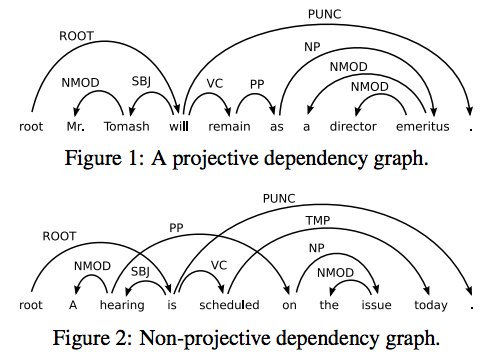

Our parser is restricted to projective graphs only, therefore we need a code to filter them. We present here a naive function that returns whether a tree is projective or not by brute checking every pair of arcs.

In [5]:
def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue

    # Determine the arc span (from left to right) and the position of the parent
    left = min(i, tree[i])
    right = max(i, tree[i])

    # Check if left-arc words have parents inside the arc span
    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    # Check if words inside the arc span have parents outside the arc span
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    # Check if right-arc words have parents inside the arc span
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False
  return True

Below the dataset is re-loaded, but this time split into training, evaluation and test dataset. Then, for the training set, only projective sentences are kept.

In [6]:
train_dataset = load_dataset('universal_dependencies', 'ga_idt', split="train")
dev_dataset = load_dataset('universal_dependencies', 'ga_idt', split="validation")
test_dataset = load_dataset('universal_dependencies', 'ga_idt', split="test")

In [7]:
train_dataset = [sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]

Let's visualise  the differences in our dataset after the removal of non-projective sentences.

In [8]:
print("Number of samples after filtering:")
print("Train: \t before:",dataset['train'].num_rows, "----> after: ", len(train_dataset))
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

Number of samples after filtering:
Train: 	 before: 4005 ----> after:  3353
Dev:	 451
Test:	 454


In [9]:
train_instances = dataset['train'].num_rows
training_projective = len(train_dataset)
training_non_projective = train_instances - training_projective
dev_instances = dataset['validation'].num_rows
n_dev_non_projective = dev_instances - len([sample for sample in dev_dataset if is_projective([-1] + [int(head) for head in sample["head"]])])
test_instances = dataset['test'].num_rows
n_test_non_projective = test_instances - len([sample for sample in test_dataset if is_projective([-1] + [int(head) for head in sample["head"]])])
removed_perc = round((training_non_projective / train_instances), 4)

print(f"A percentace of {removed_perc * 100}% sentences was removed from the train dataset because they were non-projective")

A percentace of 16.28% sentences was removed from the train dataset because they were non-projective


Only a minority of the original dataset - about 16 % - was removed, which suggests that Irish might be a language mostly composed of projective sentences.  Below we visualise the ratio between projective and non-projective sentences in our dataset.

In [ ]:
def get_colors(n, palette='YlGnBu'):
  cmap = colormaps[palette]
  colors = []
  print(cmap)
  for i in list(np.linspace(0, 1, n)):
    rgba = cmap(i)
    colors.append(matplotlib.colors.rgb2hex(rgba))
  return colors

col_palette = colors = get_colors(12)

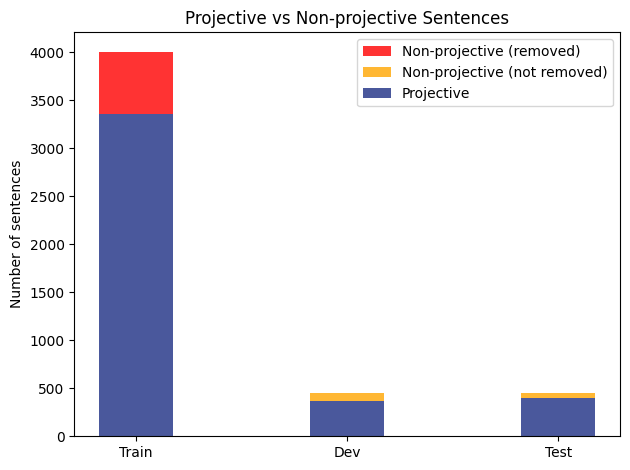

In [11]:
categories = ['Train', 'Dev', 'Test']
projective_values = [training_projective, (dev_instances - n_dev_non_projective), (test_instances - n_test_non_projective)]
non_projective_values = [training_non_projective, n_dev_non_projective, n_test_non_projective]
fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.8

rects1 = ax.bar(categories, projective_values, bar_width, alpha=opacity, color=col_palette[-2], label='Projective')
rects2 = ax.bar(categories, non_projective_values, bar_width, alpha=opacity, color=['red', 'orange', 'orange'], label=['Non-projective (removed)', 'Non-projective (not removed)', 'Non-projective (not removed)'], bottom=projective_values)

ax.set_xlabel('')
ax.set_ylabel('Number of sentences')
ax.set_title('Projective vs Non-projective Sentences')

handles, labels = ax.get_legend_handles_labels()
displayed_handles = [handles[0], handles[1], handles[3]]
displayed_labels = [labels[0], labels[1], labels[3]]
ax.legend(displayed_handles, displayed_labels)

plt.tight_layout()
plt.show()

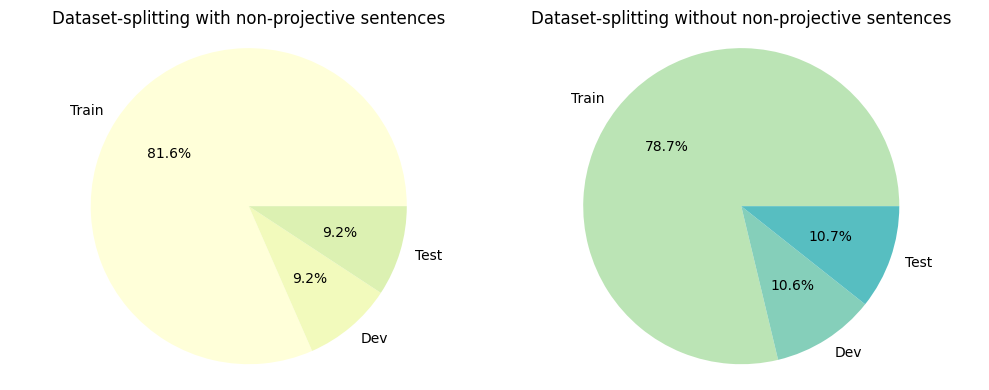

In [12]:
labels = ['Train', 'Dev', 'Test']
left_lengths = [train_instances, dev_instances, test_instances]
left_colors = col_palette[:3]
right_lengths = [len(train_dataset), len(dev_dataset), len(test_dataset)]
right_colors = col_palette[3:]
fig, axs = plt.subplots(1, 2, figsize=(10, 4))


axs[0].pie(left_lengths, labels=labels, autopct='%1.1f%%', colors=left_colors)
axs[0].set_title('Dataset-splitting with non-projective sentences')
axs[0].axis('equal')
axs[1].pie(right_lengths, labels=labels, autopct='%1.1f%%', colors=right_colors)
axs[1].set_title('Dataset-splitting without non-projective sentences')
axs[1].axis('equal')

plt.tight_layout()
plt.show()

### Dataset origins

The original Treebank contains 4910 sentences. The first 2924 of which were taken from the New Corpus of Ireland-Irish (NCII), with text from books, newswire, websites and other media. These sentences are a subset of a gold-standard POS-tagged corpus for Irish made available by Elaine Uí Dhonnchadha of Trinity College Dublin. The subsequent 1986 sentences were taken from a corpus of Irish public administration translations and are available under the Open Data (PSI) directive for sharing of pubic data: Citizens information website (CIW); (20%) Dublin City Council (DCC); (25%) Department of Culture, Heritage and the Gaeltacht (DCHG); (25%) EUbookshop (EuB); (9%) Udaras na Gaeltachta (UnGA) - an Irish governmental agency responsible for the economic, social, and cultural development of the Gaeltacht regions.

In [13]:
New_Corpus_of_Ireland_Irish = 2924
new_data = 4910 - 2924
new_data_perc = new_data / 4910

NCII_per = round(2924/4910, 2)
CIW_per = round(0.20 * new_data_perc,2)
Citizens_information_website = new_data * CIW_per
DCC_per = round(0.25 * new_data_perc, 2)
Dublin_City_Council = new_data * DCC_per
DCHG_per = round(0.09 * new_data_perc, 2)
Dep_Cult_Her = new_data * DCHG_per
UnGa_per = round(0.25 * new_data_perc, 2)
Udaras_na_Gaeltachta = new_data * UnGa_per
EuB_per = round(0.21 * new_data_perc, 2)
EUbookshop = new_data * EuB_per

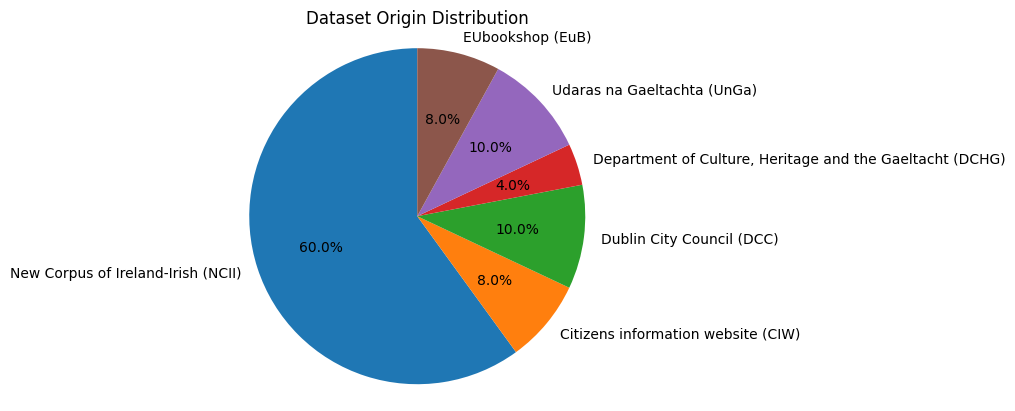

In [14]:
labels = ['New Corpus of Ireland-Irish (NCII)', 'Citizens information website (CIW)',
          'Dublin City Council (DCC)', 'Department of Culture, Heritage and the Gaeltacht (DCHG)',
          'Udaras na Gaeltachta (UnGa)', 'EUbookshop (EuB)']
percentages = [NCII_per, CIW_per, DCC_per, DCHG_per, UnGa_per, EuB_per]

plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Dataset Origin Distribution')

plt.show()

### Sentence length distribution

Another metric to analyse is the sentence length distribution. We will visualise it through a classic histogram as well as a violin plot. From the graphs we can conclude that the sentences lenght follow a right skewed distribution.

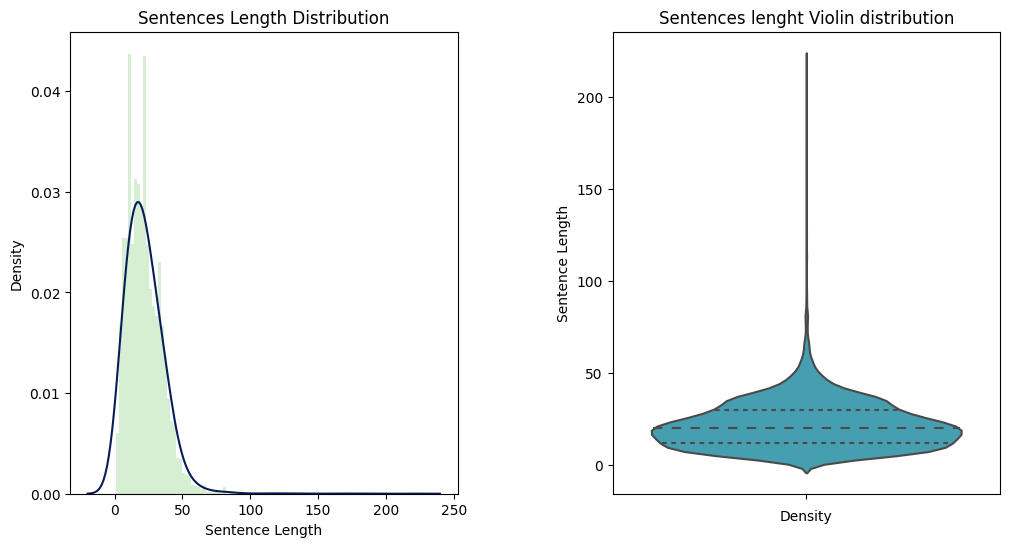

In [15]:
train_lengths = [len(x['tokens']) for x in train_dataset]
dev_lengths = [len(x['tokens']) for x in dev_dataset]
test_lengths = [len(x['tokens']) for x in test_dataset]
sentences_len = train_lengths + dev_lengths + test_lengths

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(sentences_len, bins='auto', alpha=0.6, color=col_palette[3], density=True)
sns.kdeplot(sentences_len, color=col_palette[-1], bw_method=0.5, ax=ax1)
ax1.set_xlabel('Sentence Length')
ax1.set_ylabel('Density')
ax1.set_title("Sentences Length Distribution")

sns.violinplot(y=sentences_len, color=col_palette[6], inner="quartile", ax=ax2)
ax2.set_title("Sentences lenght Violin distribution")
ax2.set_xlabel("Density")
ax2.set_ylabel("Sentence Length")

plt.subplots_adjust(wspace=0.4)
plt.show()

In [16]:
print("Sentences length on average: ", round(np.mean([len(x['tokens']) for x in train_dataset])))

Sentences length on average:  22


### Types / Tokens

According to NLP conventions, we distinguish two ways of talking about words: "**Types** are the number of distinct words in a corpus; if the set of words in the vocabulary is V, the number of types is the word token vocabulary size |V|. **Tokens** are the total number N of running words" [[source: Jurafsky, Martin 2023]](https://web.stanford.edu/~jurafsky/slp3/).

In [17]:
train_tokens = [token for x in train_dataset for token in x['tokens']]
train_types = set(train_tokens)
dev_tokens = [token for x in dev_dataset for token in x['tokens']]
dev_types = set(dev_tokens)
test_tokens = [token for x in test_dataset for token in x['tokens']]
test_types = set(test_tokens)

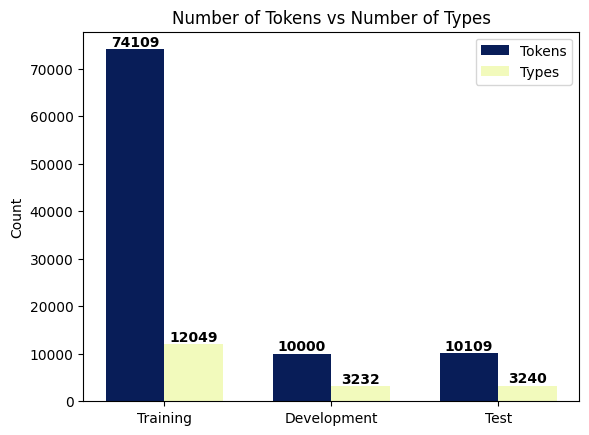

In [18]:
fig, ax = plt.subplots()

bar_width = 0.35
labels = ['Training', 'Development', 'Test']
r1 = range(len(labels))
r2 = [x + bar_width for x in r1]

ax.bar(r1, [len(train_tokens), len(dev_tokens), len(test_tokens)], color=col_palette[-1], width=bar_width, label='Tokens')
ax.bar(r2, [len(train_types), len(dev_types), len(test_types)], color=col_palette[1], width=bar_width, label='Types')

ax.set_xticks([x + bar_width/2 for x in range(len(labels))])
ax.set_xticklabels(labels)
ax.set_ylabel('Count')
ax.set_title('Number of Tokens vs Number of Types')
ax.legend()

for i, v in enumerate([len(train_tokens), len(dev_tokens), len(test_tokens)]):
  ax.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')
for i, v in enumerate([len(train_types), len(dev_types), len(test_types)]):
  ax.text(i + bar_width, v + 10, str(v), ha='center', va='bottom', fontweight='bold')

plt.show()

A **Word Cloud** is a visual representation of text data where tags are single words and their frequency is shown with font size.

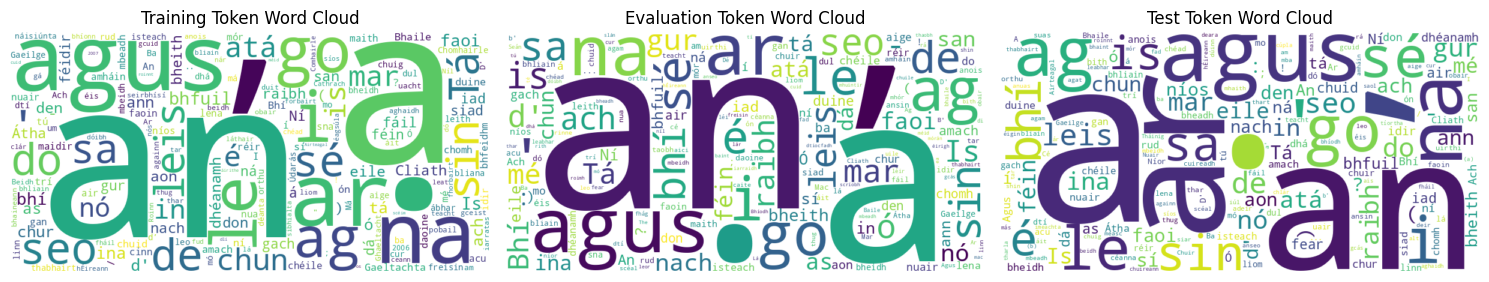

In [19]:
train_token_counts = Counter(train_tokens)
dev_token_counts = Counter(dev_tokens)
test_token_counts = Counter(test_tokens)

train_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(train_token_counts)
dev_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dev_token_counts)
test_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(test_token_counts)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(train_wordcloud, interpolation='bilinear')
ax1.set_title('Training Token Word Cloud')
ax1.axis('off')
ax2.imshow(dev_wordcloud, interpolation='bilinear')
ax2.set_title('Evaluation Token Word Cloud')
ax2.axis('off')
ax3.imshow(test_wordcloud, interpolation='bilinear')
ax3.set_title('Test Token Word Cloud')
ax3.axis('off')

plt.tight_layout()
plt.show()

#### **Zipf-Mandelbrot Law**

The Zipf-Mandelbrot law is an empirical law that describes the frequency of occurrence of different tokens. For very large datasets, the frequency $f(r)$ scales to the rank as:

$$ f(r) \propto \frac{1}{{(r + \beta)}^{\alpha}} $$

where $\alpha$ is approximately 1 and $\beta$ is approximately 2.7.


In [20]:
tokens = [token for block in dataset for x in dataset[block] for token in x['tokens']]
types = set(tokens)

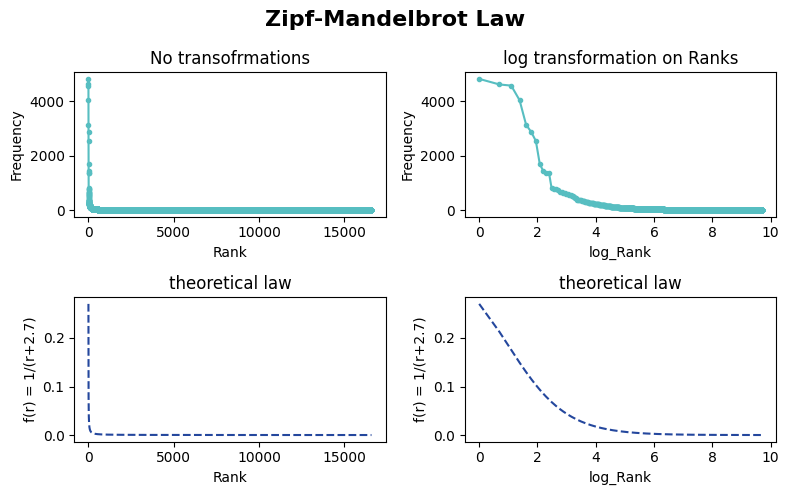

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 5))

freq_dist = FreqDist(tokens)
sorted_tokens = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)
ranks = list(range(1, len(sorted_tokens) + 1))
frequencies = [freq for _, freq in sorted_tokens]

ax1.plot(ranks, frequencies, marker='.', linestyle='-', color=col_palette[5])
ax1.set_xlabel('Rank')
ax1.set_ylabel('Frequency')
ax1.set_title('No transofrmations')
ax2.plot(np.log(ranks), frequencies, marker='.', linestyle='-', color=col_palette[5])
ax2.set_xlabel('log_Rank')
ax2.set_ylabel('Frequency')
ax2.set_title('log transformation on Ranks')
ax3.plot(ranks, 1 / (np.array(ranks) + 2.7), linestyle='--', color=col_palette[9], label='f(r) = 1/(r+2.7)')
ax3.set_xlabel('Rank')
ax3.set_ylabel('f(r) = 1/(r+2.7)')
ax3.set_title('theoretical law')
ax4.plot(np.log(ranks), 1 / (np.array(ranks) + 2.7), linestyle='--', color=col_palette[9], label='f(r) = 1/(r+2.7)')
ax4.set_xlabel('log_Rank')
ax4.set_ylabel('f(r) = 1/(r+2.7)')
ax4.set_title('theoretical law')

fig.suptitle('Zipf-Mandelbrot Law', fontsize=16, fontweight='bold')
fig.tight_layout()
plt.show()

It's interesting to note that the data is approximating the distribution as expected theoretically: few top-tokens are extremely frequent whilst most of tokens appear rarely. Note that, on right-side graphs, a logarithmic transformation to the rank values have been applied for plotting purposes. Moreover, as aspected, it's interesting to point out that most frequent tokens are either punctuation symbols or other grammatical particles such as prepositions or articles.

In [22]:
freq_dist

FreqDist({'a': 4829, '.': 4624, 'an': 4582, ',': 4045, 'agus': 3143, 'ar': 2865, 'na': 2541, 'i': 1697, 'go': 1441, 'le': 1366, ...})

#### **Heardan-Heaps Law**

The Heardan-Heaps law is an empirical law that expresses the relationship between the number of distinct words - size of vocabulary |V| - in a document and the document length - N, number of tokens. t can be formulated as follows:

$$ |V| = kN^\beta $$

Where usually $k$ ranges between 10 and 100 and $\beta$ between 0.4 and 0.75.

In [23]:
N_size = len(tokens)
V_size = len(types)
print(f"Vocabulary size |V| = {V_size} ")
print(f"Number of tokens N = {N_size}")
print(f"Heaps'approximation = {round(49*pow(N_size, 0.5), 2)}")

Vocabulary size |V| = 16590 
Number of tokens N = 115969
Heaps'approximation = 16686.57


Indeed, by selecting $k = 49$ and $\beta = 0.5$ the result is:
$$ kN^\beta = 49\cdot115969^{0.5} \approx 16687 \approx |V| $$

## Arc Eager

The arc-eager transition system was described by Joakim Nivre in the paper published in 2003: *An efficient algorithm for projective dependency parsing* [[source]](https://aclanthology.org/W03-3017.pdf).
Its **configuration** is a triple of the form  (𝜎, 𝛽, 𝐴),  where:

- **𝜎**  is the stack, where 𝜎[𝑖] (𝑖≥1) stands for the 𝑖-th token in the stack;

- 𝛽  is the input buffer, where also 𝛽[𝑖]  (𝑖≥1) is to be considered the 𝑖-th token in the buffer;

- 𝐴  is a set of arcs constructed up to that point.

The parser can perform four types of actions (**transitions**):

- **Left-Arc** (LA), which creates the arc  (𝛽[1]→𝜎[-1]) , and removes  𝜎[-1] from the stack. Note that for 𝜎[-1] we are referring to the last element of the stack. It is subject to the constrains that: 𝜎[-1] can not be the root and can not already have a father.
- **Right-Arc** (RA), which creates the arc (𝜎[-1]→𝛽[1]), pops 𝛽[1] from the buffer and place it on the top of the stack.
- **Shift** (SH), which removes 𝛽[1] from the buffer and pushes it into the stack;
- **Reduce** (RE), which removes the top-most element of the stack 𝜎[-1]. It is subject to the precondition that 𝜎[-1] has already a father.

Both the image below and the one presented in the Oracle section are taken from [[Goldber, Nivre 2012]](https://aclanthology.org/C12-1059.pdf).

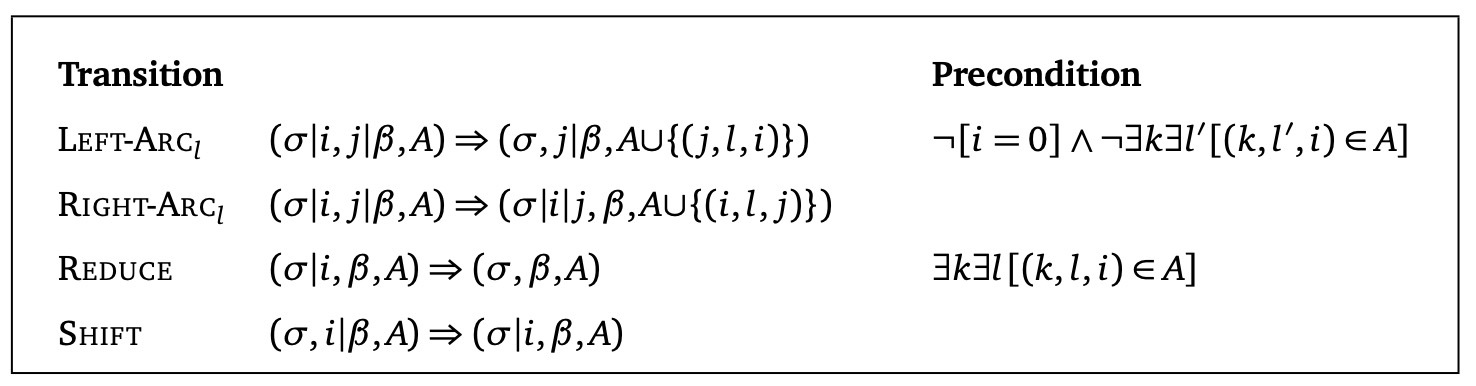

Let $w = w_0w_1\ldots w_n$ denote the input sentence where $w_0$ represents the special symbol $\text{[ROOT]}$. The stack and buffer are implemented as lists of integers, where each index $j$ corresponds to the word $w_j$. The top-most token in the stack is located at the right end of the list, while the first token in the buffer is positioned at the left end. The set $A$ is represented as an array called "arcs" with a size of $n+1$. If there exists an arc $(w_i \rightarrow w_j)$ in $A$, then the value of `arcs[j]` is assigned as $i$. In cases where the word $w_j$ is yet to have its head node in the tree under construction, `arcs[j]=-1`. It is worth noting that roots' arcs are always equal to -1, `arcs[0]=-1`. This particular representation is also applicable for complete dependency trees.

In [24]:
class ArcEager:
  def __init__(self, sentence):
    self.sentence = sentence
    self.buffer = [i for i in range(len(self.sentence))]
    self.stack = []
    self.arcs = [-1 for _ in range(len(self.sentence))]
    self.moves = []
    self.last_move = 'None'

    # root in the buffer
    self.stack.append(self.buffer.pop(0))

  def shift(self):
    self.stack.append(self.buffer.pop(0))
    self.moves.append(3)
    self.last_move = 'shift'

  def left_arc(self):
    s = self.stack.pop()
    b = self.buffer[0]
    self.arcs[s] = b
    self.moves.append(0)
    self.last_move = 'left_arc'

  def right_arc(self):
    s = self.stack[-1]
    b = self.buffer.pop(0)
    self.arcs[b] = s
    self.stack.append(b)
    self.moves.append(1)
    self.last_move = 'right_arc'

  def reduce(self):
    self.stack.pop()
    self.moves.append(2)
    self.last_move = 'reduce'


  def is_tree_final(self):
    return len(self.buffer) == 0

  def print_configuration(self):
    s = [self.sentence[i] for i in self.stack]
    b = [self.sentence[i] for i in self.buffer]
    print(s, b)
    print(self.last_move)
    print(self.arcs)
    print(self.moves)

## Oracle

A static oracle is responsible for assigning actions to parser configurations 𝑐 based on the reference tree of the sentence being analysed. If 𝑐 does not have any errors, the oracle will provide a correct action for it. Additionally, if there are multiple correct actions for 𝑐, the oracle consistently selects a single action known as the canonical action.

The Arc-Eager oracle is based on the following **conditions**:

- set  𝐴  in configuration  𝑐  does not contain any wrong dependency.

- Left-arc has precedence over other actions, and can be done only if it constructs a gold dependency, and if the top-stack element does not already have a father and it's not the root.
- Right-arc can be done only if it constructs a gold dependency.
- Reduce is subject to the preconditions that the top token has a head.
- Shift transition can be done if the buffer is not empty.
- The oracle stops whenever the buffer is empty.


The arc-eager system presents only one ambiguity, that is the choice between the moves SH-RE. Generally, whenever there is a SH-RE ambiguity, the oracle prediction will always be SH. In this way, the oracle implicitly defines a **canonical transition** sequence for every tree. Here below is reported a script for a standard oracle for arc-eager dependency parsing.

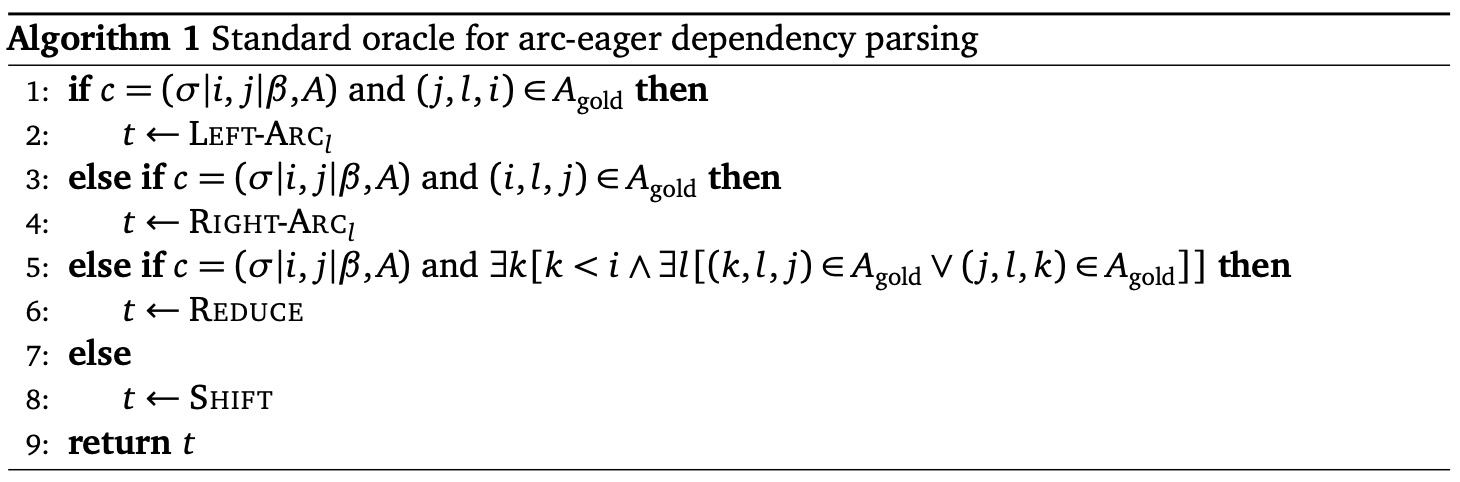

Based on the above pseudo-code, we developed the following Python code.

In [25]:
class Oracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree

  def is_left_arc_gold(self):
    s = self.parser.stack[-1]
    b = self.parser.buffer[0]

    if self.gold[s] == b and not(s == 0):
      return True

    return False

  def is_right_arc_gold(self):
    s = self.parser.stack[-1]
    b = self.parser.buffer[0]

    if self.gold[b] == s:
      return True

    return False

  def is_reduce_gold(self):
    b = self.parser.buffer[0]
    for i in self.parser.stack[:-1]:
      if self.gold[i] == b or self.gold[b] == i:
        return True

    return False

  def is_shift_gold(self):
    #This dictates transition precedence of the parser
    if (self.is_left_arc_gold() or self.is_right_arc_gold() or self.is_reduce_gold()):
      return False

    return True

## Data set-up and training

In order to effectively operate the arc-eager parser, we need a classifier capable of selecting the most suitable action within the current parser configuration. To accomplish this, the training of said classifier necessitates the <u>conversion of the gold trees</u> present in our treebank into multiple <u>pairs comprising configuration and corresponding gold action</u>.

#### **Words Dictionary**

We construct a dictionary comprising word/index pairs, which will be instrumental in the future creation of word embeddings. It is noteworthy that words with fewer than three occurrences are omitted from encoding and will be represented by a special token, namely `[UNK]`.

In [26]:
def create_dict(dataset, threshold=3):
    word_counts = defaultdict(int)
    for sample in dataset:
        for word in sample['tokens']:
            word_counts[word] += 1

    word_map = {"[PAD]": 0, "[ROOT]": 1, "[UNK]": 2}

    next_index = 3
    for word, count in word_counts.items():
        if count >= threshold:
            word_map[word] = next_index
            next_index += 1

    return word_map

word_dictionary = create_dict(train_dataset)
print(f"Size of the dictionary |V| = {len(word_dictionary)}")

Size of the dictionary |V| = 2962


The subsequent function serves for data processing and the **creation of** actual **training samples**. Each sentence within the dataset undergoes an oracle-guided computation, which yields the canonical action. Consequently, we collect pairs of configurations and corresponding canonical actions: as our neural classifier exclusively focuses on the states 𝜎[-1] and 𝛽[1], it is unnecessary to record the complete parser configuration. To each sentence a starting token "[ROOT]" is added with its head equal to -1 (as it doesn't depend by any other word).

In [27]:
def process_sample(sample, get_gold_path = False):

  # put sentence and gold tree in our format
  text = "[ROOT] " + sample["text"]
  sentence = ["[ROOT]"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"]]  #heads in the gold tree are strings, we convert them to int

  # embedding ids of sentence words
  enc_sentence = [word_dictionary[word] if word in word_dictionary else word_dictionary["[UNK]"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 reduce, 3 shift

  if get_gold_path:  # only for training
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():

      gold_path.append([parser.stack[-1], parser.buffer[0]])

      # save gold move
      if oracle.is_left_arc_gold():
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(2)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(3)


  return text, enc_sentence, gold_path, gold_moves, gold, sentence

**Prepare batches** - each item in the batch is composed by parallel arrays: texts, emb_sentences, paths, moves, trees, and sentences

In [28]:
def prepare_batch(batch_data, get_gold_path=False):
  data = [process_sample(s, get_gold_path=get_gold_path) for s in batch_data]

  texts = [s[0] for s in data]
  emb_sentences = [s[1] for s in data]
  paths = [s[2] for s in data]
  moves = [s[3] for s in data]
  trees = [s[4] for s in data]
  sentences = [s[5] for s in data]
  return texts, emb_sentences, paths, moves, trees, sentences

**Data-loaders** for train, development and test sets.

In [29]:
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

## Baseline model: biLSTM

The first type of classifiers will be composed by two parts:

- a **Bi-LSTM** to represent words together with their contexts,

- and a Multilayer Perceptron (**MLP**) to predict the next move of the parser.

LSTM is a type of RNNs that cleverly introduced self-loops to produce paths where the gradient can ﬂow for long durations and thus keep context information for longer time [source: [Hochreiter,Schmidhuber, 1997](https://deeplearning.cs.cmu.edu/S23/document/readings/LSTM.pdf)]. Basic LSTM uses information from the left (prior) context to make its predictions at time t, but in this application we have access to the entire input sequence: we want therefore to use words from the whole context (also from the right of t). BiLSTM does that, by running two separate LSTMs, one left-to-right, and one right-to-left, and concatenate their representations.

In [30]:
class LSTMnet(nn.Module):

  def __init__(self, device):
    super(LSTMnet, self).__init__()
    self.device = device
    # initial embedding layer
    self.embeddings = nn.Embedding(len(word_dictionary), EMBEDDING_SIZE, padding_idx=word_dictionary["[PAD]"])

    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    # initialize feedforward
    self.w1 = torch.nn.Linear(4*LSTM_SIZE, MLP_SIZE, bias=True)
    activation_functions = {'sigmoid': torch.nn.Sigmoid(), 'relu': torch.nn.ReLU(), 'tanh': torch.nn.Tanh(), 'leaky_relu': torch.nn.LeakyReLU()}
    assert act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.activation = activation_functions[act_fun]
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    #self.softmax = torch.nn.Softmax(dim=-1) # uncomment to use cross-entropy loss

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, x, texts, paths, sentences):

    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    h = self.lstm_pass(x)

    mlp_input = self.get_mlp_input(paths, h)

    out = self.mlp(mlp_input)

    return out

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (max_sentences_length, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    # return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x)))))) # to use with cross-entropy loss
    return self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))) # to use with custom loss (hinge loss)

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x, texts, sentences):

    parsers = [ArcEager(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers], [parser.moves for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1]
      else:
        conf = [parser.stack[-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  def parse_step(self, parsers, moves):

    moves_argm = moves.argmax(-1) #takes idx of move most likely to be correct according to the model

    for i in range(len(parsers)): # for each sentence in the batch

      if parsers[i].is_tree_final():
        continue

      σ = parsers[i].stack[-1]
      # if σ is not the ROOT and has no head
      has_no_head = bool(parsers[i].arcs[σ] == -1)
      is_not_root = bool(parsers[i].stack[-1] != 0)
      shift_condition = bool(len(parsers[i].buffer) > 1)

      #LEFT ARC
      if moves_argm[i] == 0:
        if is_not_root and has_no_head:
          parsers[i].left_arc()
        #if is the root try either right_head or shift
        elif not(is_not_root):
          if moves[i][1] > moves[i][3]:
            parsers[i].right_arc()
          else:
            parsers[i].shift()
        #if it has already a head all moves are possible
        elif not(has_no_head):
          if moves[i][1] > moves[i][3] and moves[i][1] > moves[i][2]:
            parsers[i].right_arc() #do right arc
          elif moves[i][2] > moves[i][3] or not(shift_condition):
            parsers[i].reduce()
          else:
            parsers[i].shift()

      #RIGHT ARC
      elif moves_argm[i] == 1:
          parsers[i].right_arc()

      #REDUCE
      elif moves_argm[i] == 2:
        #if top token has a father
        if not(has_no_head):
          parsers[i].reduce()
        #if top token has not a father
        else:
          if is_not_root and moves[i][0]>moves[i][1] and moves[i][0]>moves[i][3]:
            parsers[i].left_arc()
          elif moves[i][1] > moves[i][3] or not(shift_condition):
              parsers[i].right_arc()
          else:
              parsers[i].shift()

      #SHIFT
      elif moves_argm[i] == 3:
        if shift_condition:
          parsers[i].shift()
        elif moves[i][0] > moves[i][1] and is_not_root and has_no_head:
          parsers[i].left_arc()
        elif moves[i][1] > moves[i][3] or not(shift_condition):
          parsers[i].right_arc()
        else:
          parsers[i].reduce()


#### On the Parse_step architectural choices

Our classifier, while generally effective, may occasionally make incorrect predictions or select moves that contravene the Arc-Eager preconditions. To address this, we have implemented constraints to verify the validity of the predicted moves. For each move we establish the following criteria implemented in the parse_step definition above:

- If the parser erroneously predicts a LA (Left-Arc) move, it indicates that either the top element of the stack is the root or it already has a parent (as per the preconditions outlined in the Oracle section):
  - In the case where the top element is the root, only two moves, RA or SH, are permissible. We select the move that is deemed most likely by the parser.
  - If the element 𝜎[-1] already has a parent, all remaining moves are viable. Once again, we consider the most probable move predicted by the model, adhering to the following order: RA first, followed by SH, and finally RE. It is worth noting that when the buffer consists of only one remaining element, the model is restricted from selecting SH, as this would result in concluding the parsing with the final node lacking a parent.

- Whenever the parser opts for an RA move, it is executed without any limitations.

- In the case of selecting RE as the move, it is imperative to ensure that 𝜎[-1] has a parent. If this condition is not met, we examine the second most probable move predicted, employing a similar approach as described for LA, and applying the same constraints.

- Lastly, if the most likely move predicted is SH, we verify that the buffer contains more than one element. If the buffer consists of a single element, we enforce the adoption of another move using the aforementioned selection process applied for LA and SH.

### Train and Test

In [31]:
def evaluate(gold_trees, preds_trees, gold_moves, preds_moves):
  total = 0
  correct_arcs = 0
  correct_tree = 0
  correct_non_proj = 0

  for g, p in zip(gold_trees, preds_trees):
    flag = True
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct_arcs += 1
      else:
        flag = False
    if not(is_projective(g)) and flag:
        correct_non_proj += 1
    correct_tree += flag

  unified_gold_moves = []
  unified_pred_moves = []

  for g, p in zip(gold_moves, preds_moves):
    if len(g) > len(p):
      a = p + [-1 for _ in range(len(g)-len(p))]
      b = g.copy()
    elif len(g) < len(p):
      a = p.copy()
      b = g + [-1 for _ in range(len(p)-len(g))]
    else:
      a = p.copy()
      b = g.copy()
    unified_gold_moves += a
    unified_pred_moves += b

  classes = [0,1,2,3,-1]
  cm = confusion_matrix(unified_gold_moves, unified_pred_moves, labels=classes)

  return correct_arcs/total, correct_tree/len(gold_trees), correct_non_proj, cm

In [32]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    texts, emb_sentences, paths, moves, trees, sentences = batch
    out = model(emb_sentences, texts, paths, sentences)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

def test(model, dataloader):
  model.eval()

  gold_trees = []
  preds_trees = []
  gold_moves = []
  preds_moves = []

  for batch in dataloader:
    texts, emb_sentences, paths, moves, trees, sentences = batch
    with torch.no_grad():
      pred_trees, pred_moves = model.infere(emb_sentences, texts, sentences)

      gold_trees += trees
      preds_trees += pred_trees
      gold_moves += moves
      preds_moves += pred_moves

  return evaluate(gold_trees, preds_trees, gold_moves, preds_moves)

We are now ready to train our parser on the dataset. In this section, two variations of the BiLSTM are run:

1. A base **BiLSTM** that that we will simply call BiLSTM. It will be trained setting the following parameters:

|    Parameter    | Value |
|:---------------:|-------|
| EMBEDDING_SIZE  |  200  |
|   LSTM_SIZE     |  200  |
|  LSTM_LAYERS    |   1   |
|     EPOCHS      |  15   |


2. An improved version of the above model, with the same parameters but with **2 layers**. We will call it **BiLSTM_2L**.

|    Parameter    | Value |
|:---------------:|-------|
| EMBEDDING_SIZE  |  200  |
|   LSTM_SIZE     |  200  |
|  LSTM_LAYERS    |   **2**   |
|     EPOCHS      |  15   |

Moreover, we are going to train both of them on different learning rates, dropout values and activation functions. We will implement a dictionary in order to manage more easly the search of the best hyperparameters. Comparisations over all the performances will be held further on.   

#### Grid-Search Dictionary


We start by creating a dictionary, named *config*, that contains all the hyperparameters that we are going to test. Specifically, there are 12 combinations, so "run" variable can take a value between 1 and 12, each corresponding to a configuration.



In [33]:
run = 2 # the best model's configuration for LSTM_L2

In [34]:
learning_rates = [0.001, 0.0005]
activations = ['relu', 'tanh']
drop = [0.2, 0.3, 0.5]

config = dict()
i = 1
for lr in learning_rates:
  for a in activations:
    for d in drop:
      config[str(i)] = dict (learning_rate = lr,
                             DROPOUT = d,
                             act_function = a)
      i += 1

In [ ]:
config_LSTM = config[str(run)] | {'LSTM_LAYERS': 2}
name='-'.join(str(e) for e in config[str(run)].values())

wandb.init(
  project="Arc-Eager with BiLSTM 2 Layer",
  name=name,
  notes="BiLSTM baseline",
  config=config_LSTM,
)

EMBEDDING_SIZE = 200
LSTM_LAYERS = config_LSTM['LSTM_LAYERS']
LSTM_SIZE = 200
MLP_SIZE = 200
BATCH_SIZE = 32
DROPOUT = config_LSTM['DROPOUT']
EPOCHS = 15
LR = config_LSTM['learning_rate']
act_fun = config_LSTM['act_function']

#### Plotting Function

This function is to plot the confusion matrix, together with the Accuracy, Recall and Precision matrices. More will be said about this during Error Analysis.

In [36]:
def plot_metrics(cm, savename='plot.png'):
    classes = ['left_arc','right_arc','reduce','shift','overshoot']

    colormap = 'YlGnBu'
    plt.figure(figsize=(18,12))

    plt.subplot(2, 2, 1)
    plt.title("Confusion Matrix")
    sns.heatmap(cm, annot=True, fmt="d", cmap=colormap, xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")

    plt.subplot(2, 2, 2)
    acc = []
    for i in range(5):
        acc.append(sum(np.diag(cm))/(sum(np.diag(cm))+sum(cm[i,i+1:])+sum(cm[i,:i])+sum(cm[i+1:,i])+sum(cm[:i,i]))) # accuracy
    mask = np.ones((5,5))
    np.fill_diagonal(mask,0)
    plt.title("Accuracies")
    sns.heatmap(np.diag(acc), annot=True, cmap=colormap, xticklabels=classes, yticklabels=classes, mask=mask, vmin=0.5, vmax=1)
    plt.xlabel("Labels")
    plt.ylabel("Labels")

    plt.subplot(2, 2, 3)
    plt.title("Recall Matrix")
    cm_recall = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    cm_recall = cm_recall[:4,:4]
    sns.heatmap(cm_recall, annot=True, cmap=colormap, xticklabels=classes[:4], yticklabels=classes[:4])
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")

    plt.subplot(2, 2, 4)

    plt.title("Precision Matrix")
    cm_precision = cm.astype('float')/cm.sum(axis=0)[np.newaxis, :]
    cm_precision = cm_precision[:4,:4]
    sns.heatmap(cm_precision, annot=True, cmap=colormap, xticklabels=classes[:4], yticklabels=classes[:4])
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")

    plt.savefig(savename)
    plt.show()

### Hinge Loss

Then, we define the loss functiun. To train our classifier, we are employing the hinge loss function, as we noticed an important improval with respect to the binary cross-entropy loss.

The aim is to maximizing the margin between the raw probability associated with the right move and the maximum between the raw probabilities associated with all other wrong moves. By doing so, all the distances between the move that the model must learn to predict for that configuration and all other possible wrong moves are enlarged.

Hinge Loss: $$\max(0, \text{Score}(\phi(c), op) +\max_{op'\in A\setminus G}\text{Score}(\phi(c), op'))$$

In [37]:
class HingeLoss(torch.nn.Module):

    def init(self):
        super(HingeLoss, self).init()

    def forward(self, predictions, op):
        # Calculate your custom loss here
        predictions.to(device)
        mask = torch.ones(predictions.shape, dtype=torch.bool)
        mask[torch.arange(len(op)),op] = False

        # Extract the desired columns
        filtered = predictions[mask].reshape(predictions.shape[0], predictions.shape[1]-1)

        loss =  torch.ones(len(op)).to(device) - predictions[torch.arange(len(op)).to(device),op] + torch.max(filtered, dim=-1)[0].to(device)
        loss = torch.maximum(loss.to(device), torch.zeros(loss.shape).to(device))

        return (1/len(op)) * torch.sum(loss)

#### Training Fase with Early Stopping

We train our model implementing it with an Early Stopping with a tolerance of 3, as we noticed that the model tends to overfit with too many epochs.

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model_LSTM = LSTMnet(device)
model_LSTM.to(device)

# criterion = nn.CrossEntropyLoss()
criterion = HingeLoss()
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr=LR)

# early stopping parameters
best_uas = float('-inf')
best_epoch = 0
patience = 3  # Number of epochs to wait before early stopping
counter = 0

print('MODEL: 2 layer BiLSTM \nHyperparams: ', '-'.join(str(e) for e in config[str(run)].values()))
for epoch in range(EPOCHS):
  if epoch == 0:
    val_uas, tree_acc, _, _ = test(model_LSTM, dev_dataloader)
    print("Epoch: {:3d} | avg_train_loss: {}  | dev_uas: {:5.3f} | tree_acc = {:5.3f} |".format(epoch-1, None, val_uas, tree_acc))
  avg_train_loss = train(model_LSTM, train_dataloader, criterion, optimizer)
  val_uas, tree_acc, _, _ = test(model_LSTM, dev_dataloader)
  wandb.log({"avg_train_loss": avg_train_loss, "val_uas": val_uas})
  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} | tree_acc = {:5.3f} |".format( epoch, avg_train_loss, val_uas, tree_acc))

  if val_uas > best_uas:
    best_uas = val_uas
    best_epoch = epoch
    counter = 0
    # Save the best model
    torch.save(model_LSTM.state_dict(), 'LSTM_L2_best_model.pth')
  else:
    counter += 1
  if counter >= patience:
    print(f'Early stopping at epoch {epoch}.')
    break

print(f'loaded model of epoch: {best_epoch}')
model_LSTM.load_state_dict(torch.load('LSTM_L2_best_model.pth'))

Device: cuda
MODEL: 2 layer BiLSTM 
Hyperparams:  0.001-0.3-relu
Epoch:  -1 | avg_train_loss: None  | dev_uas: 0.188 | tree_acc = 0.000 |
Epoch:   0 | avg_train_loss: 0.649 | dev_uas: 0.668 | tree_acc = 0.093 |
Epoch:   1 | avg_train_loss: 0.373 | dev_uas: 0.719 | tree_acc = 0.124 |
Epoch:   2 | avg_train_loss: 0.312 | dev_uas: 0.745 | tree_acc = 0.140 |
Epoch:   3 | avg_train_loss: 0.275 | dev_uas: 0.763 | tree_acc = 0.149 |
Epoch:   4 | avg_train_loss: 0.248 | dev_uas: 0.773 | tree_acc = 0.169 |
Epoch:   5 | avg_train_loss: 0.224 | dev_uas: 0.781 | tree_acc = 0.173 |
Epoch:   6 | avg_train_loss: 0.209 | dev_uas: 0.780 | tree_acc = 0.162 |
Epoch:   7 | avg_train_loss: 0.194 | dev_uas: 0.783 | tree_acc = 0.171 |
Epoch:   8 | avg_train_loss: 0.182 | dev_uas: 0.783 | tree_acc = 0.177 |
Epoch:   9 | avg_train_loss: 0.169 | dev_uas: 0.787 | tree_acc = 0.173 |
Epoch:  10 | avg_train_loss: 0.160 | dev_uas: 0.791 | tree_acc = 0.173 |
Epoch:  11 | avg_train_loss: 0.151 | dev_uas: 0.795 | tree_

<All keys matched successfully>

#### Test fase

In [39]:
test_uas, tree_acc, correct_non_proj_LSTM, cm_LSTM = test(model_LSTM, test_dataloader)
#print("test_uas: {:5.3f}".format(test_uas))
wandb.log({"test_uas": test_uas})
if run <10:
  plotname_LSTM = '0'+str(run)+'_BiLSTM_L2.png'
else:
  plotname_LSTM = str(run)+'_BiLSTM_L2.png'
#plot_metrics(cm_LSTM, plotname_LSTM)

In [ ]:
wandb.finish()

## BERT-based models

The second type of classifiers are retrived by substituing the BiLSTM word emebddings with BERT-based emebeddings, while the MLP classifier on top of them is kept invariant. BERT stands for Bidirectional Encoder Representations from
Transformers and basically is an encoder only transformer [[source paper]](https://arxiv.org/pdf/1810.04805.pdf). A simplify version of its architecture is displayed in the following image.

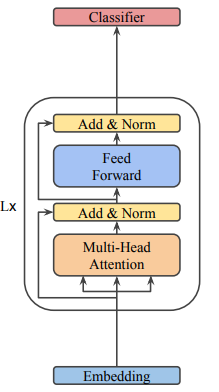

Where L is the number of blocks, which in our code will be equal to 12.

#### The Auto-Classes




We download a pretrained model and its tokenizer from the Hugging Face library [transformers](https://huggingface.co/docs/transformers/v4.27.0/en/autoclass_tutorial#automodel).
Specifically, we will use:
- ```AutoModel``` for the models.
- ```AutoTokenizer``` for the tokenization preproccesing. The tokenizer:
  - Preprocesses the text and tokenizes it in subwords.
  - Associates to every subword an ```input_ids``` which is used to fetch its embedding in the embedding layer (or layer 0).
  - Adds ```attention_mask``` and ```token_type_ids```.
  - Has a method called ```word_ids```which, for each subtoken word in a sentence gives the corrisponding index to the original word from which the subtoken was generated. This is a very important aspect as BERT assigns embeddings to each token by using WordPiece, a variation of Byte-Pair Encoding (BPE). Nonetheless, the neural classifier (MLP) requires one embedding for each word in the configuration. More about this issue will be said in "on the BERT_pass" section.

In [41]:
class BERTnet(nn.Module):

  def __init__(self, device):
    super(BERTnet, self).__init__()
    self.device = device

    # initialize BERT
    model_name = "bert-base-multilingual-uncased"
    self.BERT = AutoModel.from_pretrained(model_name, output_hidden_states = True)
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Here we freeze all/first 9 BERT layers depending on fine_tune variable
    if fine_tune:
      for param in self.BERT.encoder.layer[:10].parameters():
        param.requires_grad = False
    else:
      for param in self.BERT.encoder.layer.parameters():
        param.requires_grad = False


    # initialize feedforward
    self.w1 = torch.nn.Linear(2*EMBEDDING_SIZE, MLP_SIZE, bias=True)
    activation_functions = {'sigmoid': torch.nn.Sigmoid(), 'relu': torch.nn.ReLU(), 'tanh': torch.nn.Tanh(), 'leaky_relu': torch.nn.LeakyReLU()}
    assert act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.activation = activation_functions[act_fun]
    #self.activation = torch.nn.ReLU()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    #self.softmax = torch.nn.Softmax(dim=-1) # uncomment to use cross-entropy loss

    self.dropout = torch.nn.Dropout(DROPOUT)

  def forward(self, x, texts, paths, sentences):
    emb = self.BERT_pass(sentences)

    mlp_input = self.get_mlp_input(paths, emb)

    out = self.mlp(mlp_input)

    return out

  def BERT_pass(self, sentences):
    batch_size = len(sentences)

    # tokenize all the sentences on the batch
    batch = self.tokenizer(sentences, return_tensors='pt', add_special_tokens=False,
                           padding=True, is_split_into_words = True).to(self.device)

    # retrieve all the hidden vectors from BERT
    BERT_output = self.BERT(**batch)

    # use a mean of the last 4 hidden vector as embeddings of the tokens
    h = torch.mean(torch.stack([BERT_output.hidden_states[-1],
                                BERT_output.hidden_states[-2],
                                BERT_output.hidden_states[-3],
                                BERT_output.hidden_states[-4]]), dim = 0).to(self.device)

    # now we need to retrive the word embedding from the token embeddings for
    # every sentence in the batch
    hidden = []
    for i in range(batch_size):
        encoded_inputs = self.tokenizer(sentences[i], return_tensors="pt",
                                        add_special_tokens=False,
                                        is_split_into_words = True)
        word_ids = encoded_inputs.word_ids()
        lst = [0]
        for j in range(1, len(word_ids)):
            if word_ids[j-1] == word_ids[j]:
                lst[-1] += 1
            else:
                lst.append(0)

        hidden_sent = []
        k=0
        for j in range(len(lst)):
            if lst[j] == 0:
                hidden_sent.append(h[i, k, :])
            else:
                # we take the mean of the tokens embeddings as word embedding
                hidden_sent.append(h[i, k:(k+lst[j]+1), :].mean(dim=0).to(self.device))
                k += lst[j]
            k += 1

        for k in range(h.size(1)-len(lst)):
            hidden_sent.append(torch.zeros(EMBEDDING_SIZE, requires_grad=False).to(self.device))

        hidden_sent = torch.stack(hidden_sent).to(self.device)

        hidden.append(hidden_sent)
    return torch.permute(torch.stack(hidden).to(self.device), (1,0,2))

  def get_mlp_input(self, configurations, emb):
    mlp_input = []
    zero_tensor = torch.zeros(EMBEDDING_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat((zero_tensor if j[0]==-1 else emb[j[0], i, :], zero_tensor if j[1]==-1 else emb[j[1], i, :])))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    # return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x)))))) # to use with cross-entropy loss
    return self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))) # to use with custom loss (hinge loss)

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x, texts, sentences):

    parsers = [ArcEager(i) for i in x]

    emb = self.BERT_pass(sentences).to(self.device)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      # print(len(configurations), len(configurations[0]))
      mlp_input = self.get_mlp_input(configurations, emb)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers], [parser.moves for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1]
      else:
        conf = [parser.stack[-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  def parse_step(self, parsers, moves):

    moves_argm = moves.argmax(-1) #takes idx of move most likely to be correct according to the model

    for i in range(len(parsers)): # for each sentence in the batch

      if parsers[i].is_tree_final():
        continue

      σ = parsers[i].stack[-1]
      # if σ is not the ROOT and has no head
      has_no_head = bool(parsers[i].arcs[σ] == -1)
      is_not_root = bool(parsers[i].stack[-1] != 0)
      shift_condition = bool(len(parsers[i].buffer) > 1)

      #LEFT ARC
      if moves_argm[i] == 0:
        if is_not_root and has_no_head:
          parsers[i].left_arc()
        #if is the root try either right_head or shift
        elif not(is_not_root):
          if moves[i][1] > moves[i][3]:
            parsers[i].right_arc()
          else:
            parsers[i].shift()
        #if it has already a head all moves are possible
        elif not(has_no_head):
          if moves[i][1] > moves[i][3] and moves[i][1] > moves[i][2]:
            parsers[i].right_arc() #do right arc
          elif moves[i][2] > moves[i][3] or not(shift_condition):
            parsers[i].reduce()
          else:
            parsers[i].shift()

      #RIGHT ARC
      elif moves_argm[i] == 1:
          parsers[i].right_arc()

      #REDUCE
      elif moves_argm[i] == 2:
        #if top token has a father
        if not(has_no_head):
          parsers[i].reduce()
        #if top token has not a father
        else:
          if is_not_root and moves[i][0]>moves[i][1] and moves[i][0]>moves[i][3]:
            parsers[i].left_arc()
          elif moves[i][1] > moves[i][3] or not(shift_condition):
              parsers[i].right_arc()
          else:
              parsers[i].shift()

      #SHIFT
      elif moves_argm[i] == 3:
        if shift_condition:
          parsers[i].shift()
        elif moves[i][0] > moves[i][1] and is_not_root and has_no_head:
          parsers[i].left_arc()
        elif moves[i][1] > moves[i][3] or not(shift_condition):
          parsers[i].right_arc()
        else:
          parsers[i].reduce()

#### On the BERT_pass

As previously mentioned, the problem with using BERT to extract word embeddings is that BERT has its own vocaboulary composed of subtokens (derived from WordPiece algorithm, a variant of BPE encoding with a different merge criteria): sometimes words are splitted into subwords each of which rapresented with an embedding. Nonetheless, our neural classifier requieres only one embedding per word. Thus, for every splitted word, we need to retrieve from BERT the subtoken embeddings and merge them to compose the word embeddings. We exploited 2 different ways to do this:
- elementwise aritmetic mean of the subtokens
- take the leftmost token

We choose the first option, since it proved to be working better. To implement it, we used the <code>.word_ids()</code> to retrieve a list of the index of the word associated to every subtoken. We then created a second list of length equal to the number of words/tokens in the sentence where every element is the number of split that word has undergone. We then used this second list to merge the subtoken embeddings in token embeddings.

### Train and Test

We are going to train two variaton of BERT-based classifier:

- A base one, were we are doing ***feature extractions***: the mean of the outputs of the last 4 hidden layers will be used as emebeddings of the words and fed to the MLP as inputs, for the next configuration prediction. Note that in this process all BERT's parameters are left unchanged. We are going to call this model simply as **BERT**.

|    Parameter    | Value |
|:---------------:|-------|
| EMBEDDING_SIZE  |  768  |
|  FINE TUNING    |   FALSE   |
|     EPOCHS      |  15   |


- A more sofisticated one, where - on top of what has been done in the first model - will also be carried out ***fine-tuning***: during training the last 3 blocks parameters will be updated through gradient descent. This model will be called **BERT_ft**

|    Parameter    | Value |
|:---------------:|-------|
| EMBEDDING_SIZE  |  768  |
|  FINE TUNING    |   **TRUE**   |
|     EPOCHS      |  15   |



Additionally, we are training both models on the same configurations introduced before and stored in *config* dictionary.

In [42]:
run = 7 # Best configuration for BERT_ft

In [ ]:
config_BERT = config[str(run)] | {'fine_tune': True}
name='-'.join(str(e) for e in config[str(run)].values())

wandb.init(
  project="Arc-Eager with BERT with fine tuning of last 3 layers",
  name=name,
  notes="BERT baseline",
  config=config_BERT,
)

EMBEDDING_SIZE = 768
MLP_SIZE = 200
BATCH_SIZE = 32
DROPOUT = config_BERT['DROPOUT']
EPOCHS = 15
LR = config_BERT['learning_rate']
act_fun = config_BERT['act_function']
fine_tune = config_BERT['fine_tune']

#### Training Phase with Early Stopping

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model_BERT = BERTnet(device)
model_BERT.to(device)

# criterion = nn.CrossEntropyLoss()
criterion = HingeLoss()
optimizer = torch.optim.Adam(model_BERT.parameters(), lr=LR)

# early stopping parameters
best_uas = float('-inf')
best_epoch = 0
patience = 6  # Number of epochs to wait before early stop the training
counter = 0

print('MODEL: BERT fine tuned \nHyperparams: ', '-'.join(str(e) for e in config[str(run)].values()))
for epoch in range(EPOCHS):
  if epoch == 0:
    val_uas, tree_acc, _, _ = test(model_BERT, dev_dataloader)
    print("Epoch: {:3d} | avg_train_loss: {}  | dev_uas: {:5.3f} | tree_acc = {:5.3f} |".format(epoch-1, None, val_uas, tree_acc))
  avg_train_loss = train(model_BERT, train_dataloader, criterion, optimizer)
  val_uas, tree_acc, _, _ = test(model_BERT, dev_dataloader)
  wandb.log({"avg_train_loss": avg_train_loss, "val_uas": val_uas})
  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} | tree_acc = {:5.3f} |".format( epoch, avg_train_loss, val_uas, tree_acc))
  if val_uas > best_uas:
    best_uas = val_uas
    best_epoch = epoch
    counter = 0
    # Save the best model
    torch.save(model_BERT.state_dict(), 'BERT_ft_best_model.pth')
  else:
    counter += 1
  if counter >= patience:
    print(f'Early stopping at epoch {epoch}.')
    break

# Load best model
print(f'loaded model of epoch: {best_epoch}')
model_BERT.load_state_dict(torch.load('BERT_ft_best_model.pth'))

Device: cuda


MODEL: BERT fine tuned 
Hyperparams:  0.0005-0.2-relu
Epoch:  -1 | avg_train_loss: None  | dev_uas: 0.083 | tree_acc = 0.000 |
Epoch:   0 | avg_train_loss: 0.425 | dev_uas: 0.771 | tree_acc = 0.146 |
Epoch:   1 | avg_train_loss: 0.252 | dev_uas: 0.806 | tree_acc = 0.186 |
Epoch:   2 | avg_train_loss: 0.207 | dev_uas: 0.814 | tree_acc = 0.206 |
Epoch:   3 | avg_train_loss: 0.174 | dev_uas: 0.817 | tree_acc = 0.208 |
Epoch:   4 | avg_train_loss: 0.159 | dev_uas: 0.824 | tree_acc = 0.211 |
Epoch:   5 | avg_train_loss: 0.140 | dev_uas: 0.827 | tree_acc = 0.226 |
Epoch:   6 | avg_train_loss: 0.125 | dev_uas: 0.828 | tree_acc = 0.224 |
Epoch:   7 | avg_train_loss: 0.116 | dev_uas: 0.825 | tree_acc = 0.239 |
Epoch:   8 | avg_train_loss: 0.110 | dev_uas: 0.825 | tree_acc = 0.237 |
Epoch:   9 | avg_train_loss: 0.102 | dev_uas: 0.832 | tree_acc = 0.237 |
Epoch:  10 | avg_train_loss: 0.094 | dev_uas: 0.823 | tree_acc = 0.220 |
Epoch:  11 | avg_train_loss: 0.088 | dev_uas: 0.822 | tree_acc = 0.222

<All keys matched successfully>

#### Test Phase

In [45]:
test_uas, tree_acc, correct_non_proj_BERT, cm_BERT = test(model_BERT, test_dataloader)
#print("test_uas: {:5.3f}".format(test_uas))
wandb.log({"test_uas": test_uas})
if run < 10:
  plotname_BERT = '0'+str(run)+'_BERT-ft.png'
else:
  plotname_BERT = str(run)+'_BERT-ft.png'
#plot_metrics(cm_BERT, plotname_BERT)

In [ ]:
wandb.finish()

# Models Comparision

During our runs, we have stored in a *result* dictionary all the UAS scores of our models:

In [47]:
result = {"1": {"learning_rate": 0.001, "DROPOUT": 0.2, "act_function": "relu", "color": "#b5e2b6", "LSTM_score": "0.7757", "LSTM_L2_score": "0.7824", "BERT_score": "0.7912", "BERT_ft_score": "0.8034"},
          "2": {"learning_rate": 0.001, "DROPOUT": 0.3, "act_function": "relu", "color": "#95d5b9", "LSTM_score": "0.7727", "LSTM_L2_score": "0.7883", "BERT_score": "0.7886", "BERT_ft_score": "0.7998"},
          "3": {"learning_rate": 0.001, "DROPOUT": 0.5, "act_function": "relu", "color": "#76cabc", "LSTM_score": "0.7584", "LSTM_L2_score": "0.7772", "BERT_score": "0.7899", "BERT_ft_score": "0.7971"},
          "4": {"learning_rate": 0.001, "DROPOUT": 0.2, "act_function": "tanh", "color": "#5abfc0", "LSTM_score": "0.7626", "LSTM_L2_score": "0.7811", "BERT_score": "0.7872", "BERT_ft_score": "0.794"},
          "5": {"learning_rate": 0.001, "DROPOUT": 0.3, "act_function": "tanh", "color": "#3fb4c4", "LSTM_score": "0.7659", "LSTM_L2_score": "0.7849", "BERT_score": "0.783", "BERT_ft_score": "0.7785"},
          "6": {"learning_rate": 0.001, "DROPOUT": 0.5, "act_function": "tanh", "color": "#2fa4c2", "LSTM_score": "0.7578", "LSTM_L2_score": "0.7737", "BERT_score": "0.7723", "BERT_ft_score": "0.7779"},
          "7": {"learning_rate": 0.0005, "DROPOUT": 0.2, "act_function": "relu", "color": "#1f93c0", "LSTM_score": "0.7702", "LSTM_L2_score": "0.7794", "BERT_score": "0.8042", "BERT_ft_score": "0.8184"},
          "8": {"learning_rate": 0.0005, "DROPOUT": 0.3, "act_function": "relu", "color": "#1f7db7", "LSTM_score": "0.7671", "LSTM_L2_score": "0.7788", "BERT_score": "0.8012", "BERT_ft_score": "0.8135"},
          "9": {"learning_rate": 0.0005, "DROPOUT": 0.5, "act_function": "relu", "color": "#2166ac", "LSTM_score": "0.7453", "LSTM_L2_score": "0.7567", "BERT_score": "0.796", "BERT_ft_score": "0.8142"},
          "10": {"learning_rate": 0.0005, "DROPOUT": 0.2, "act_function": "tanh", "color": "#2352a2", "LSTM_score": "0.7622", "LSTM_L2_score": "0.7802", "BERT_score": "0.7924", "BERT_ft_score": "0.8155"},
          "11": {"learning_rate": 0.0005, "DROPOUT": 0.3, "act_function": "tanh", "color": "#243f99", "LSTM_score": "0.7616", "LSTM_L2_score": "0.7722", "BERT_score": "0.791", "BERT_ft_score": "0.8082"},
          "12": {"learning_rate": 0.0005, "DROPOUT": 0.5, "act_function": "tanh", "color": "#1f3089", "LSTM_score": "0.7411", "LSTM_L2_score": "0.7578", "BERT_score": "0.7721", "BERT_ft_score": "0.8096"}}

df_result = pd.DataFrame.from_dict(result, orient='index').drop('color', axis=1)
df_result

learning_rate  DROPOUT act_function LSTM_score LSTM_L2_score BERT_score  \
1          0.0010      0.2         relu     0.7757        0.7824     0.7912   
2          0.0010      0.3         relu     0.7727        0.7883     0.7886   
3          0.0010      0.5         relu     0.7584        0.7772     0.7899   
4          0.0010      0.2         tanh     0.7626        0.7811     0.7872   
5          0.0010      0.3         tanh     0.7659        0.7849      0.783   
6          0.0010      0.5         tanh     0.7578        0.7737     0.7723   
7          0.0005      0.2         relu     0.7702        0.7794     0.8042   
8          0.0005      0.3         relu     0.7671        0.7788     0.8012   
9          0.0005      0.5         relu     0.7453        0.7567      0.796   
10         0.0005      0.2         tanh     0.7622        0.7802     0.7924   
11         0.0005      0.3         tanh     0.7616        0.7722      0.791   
12         0.0005      0.5         tanh     0.7411        0.7578     0.7721   

   BERT_ft_score  
1         0.8034  
2         0.7998  
3         0.7971  
4          0.794  
5         0.7785  
6         0.7779  
7         0.8184  
8         0.8135  
9         0.8142  
10        0.8155  
11        0.8082  
12        0.8096

We assign a different color to each one of this configurations. This will give us a visual understanding on which configuration ranked first within each model by simply sorting the following table according to the scorses obtained.

In [48]:
df = df_result.iloc[:, :3]
df.insert(0, 'run', np.arange(1, 13))

custom_palette = ['#b5e2b6', '#95d5b9', '#76cabc', '#5abfc0', '#3fb4c4', '#2fa4c2',
                  '#1f93c0', '#1f7db7', '#2166ac', '#2352a2', '#243f99', '#1f3089', '#12256e']

cmap = ListedColormap(custom_palette)

styler = df.style.background_gradient(axis=0, gmap=df['run'], cmap=cmap).hide(axis="index")
styler.set_properties(**{'text-align': 'center'})

styler

## BiLSTM Baseline

In [49]:
df_BiLSTM = df_result.iloc[:, :4]
df_BiLSTM.insert(0, 'run', np.arange(1, 13))
df_BiLSTM = df_BiLSTM.sort_values(by='LSTM_score', ascending=False)

styler_BiLSTM = df_BiLSTM.style.background_gradient(axis=0, gmap=df_BiLSTM['run'], cmap=cmap).hide(axis="index")
styler_BiLSTM.set_properties(**{'text-align': 'center'})

html_table1 = styler_BiLSTM.to_html()
title1 = "<h2>BiLSTM Baseline</h2>"
html = f"""
<div style="display: inline-block; vertical-align: top;">
    {title1}
    {html_table1}
</div>
"""
display(HTML(html))

**TOP 4 configurations**

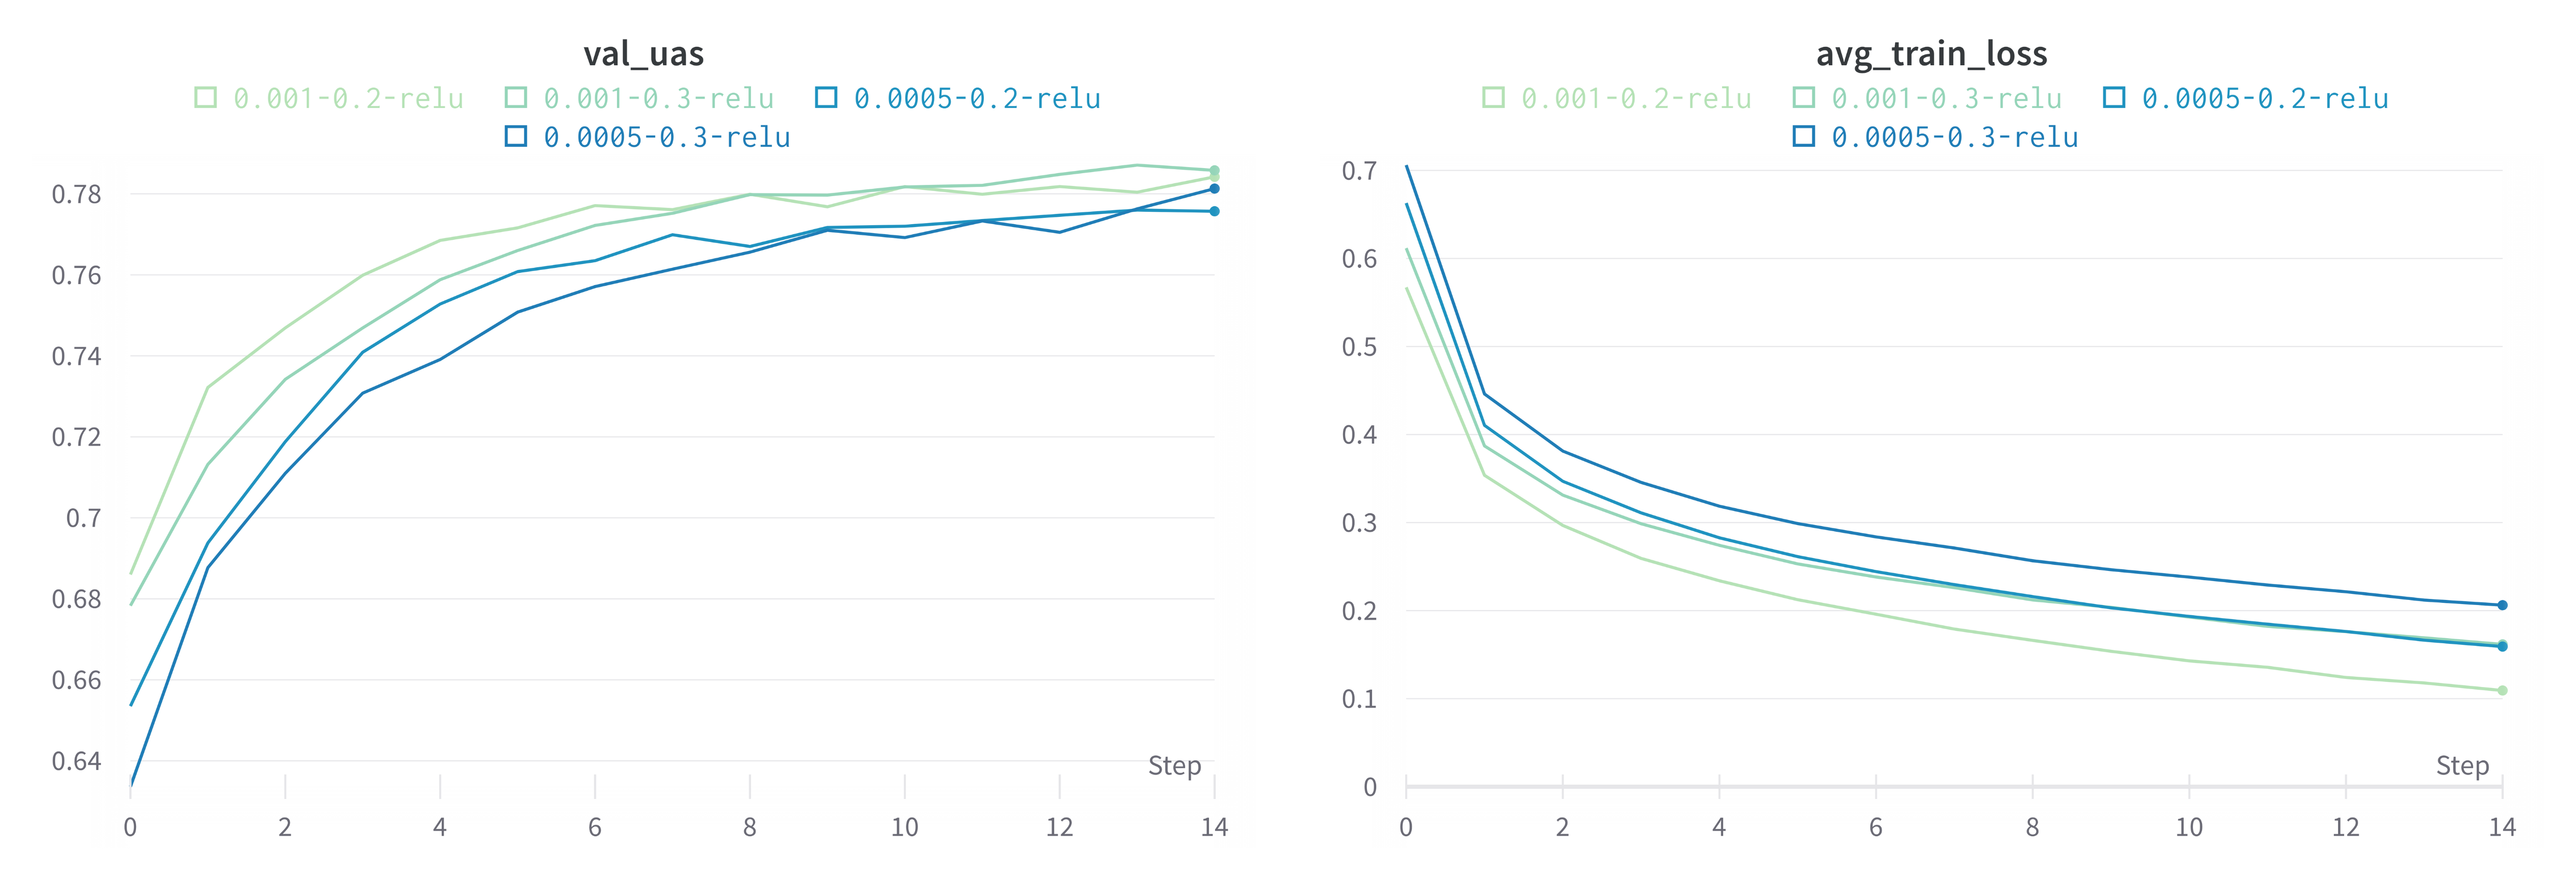

## BiLSTM 2 Layers

In [50]:
df_BiLSTM_2L = df_result.drop(['LSTM_score', 'BERT_score',	'BERT_ft_score'], axis = 1)
df_BiLSTM_2L.insert(0, 'run', np.arange(1, 13))
df_BiLSTM_2L = df_BiLSTM_2L.sort_values(by='LSTM_L2_score', ascending=False)

styler_BiLSTM_2L = df_BiLSTM_2L.style.background_gradient(axis=0, gmap=df_BiLSTM_2L['run'], cmap=cmap).hide(axis="index")
styler_BiLSTM_2L.set_properties(**{'text-align': 'center'})

html_table2 = styler_BiLSTM_2L.to_html()
title2 = "<h2>BiLSTM 2 Layers </h2>"
html = f"""
<div style="display: inline-block; vertical-align: top;">
    {title2}
    {html_table2}
</div>
"""
display(HTML(html))

**TOP 4 configurations**

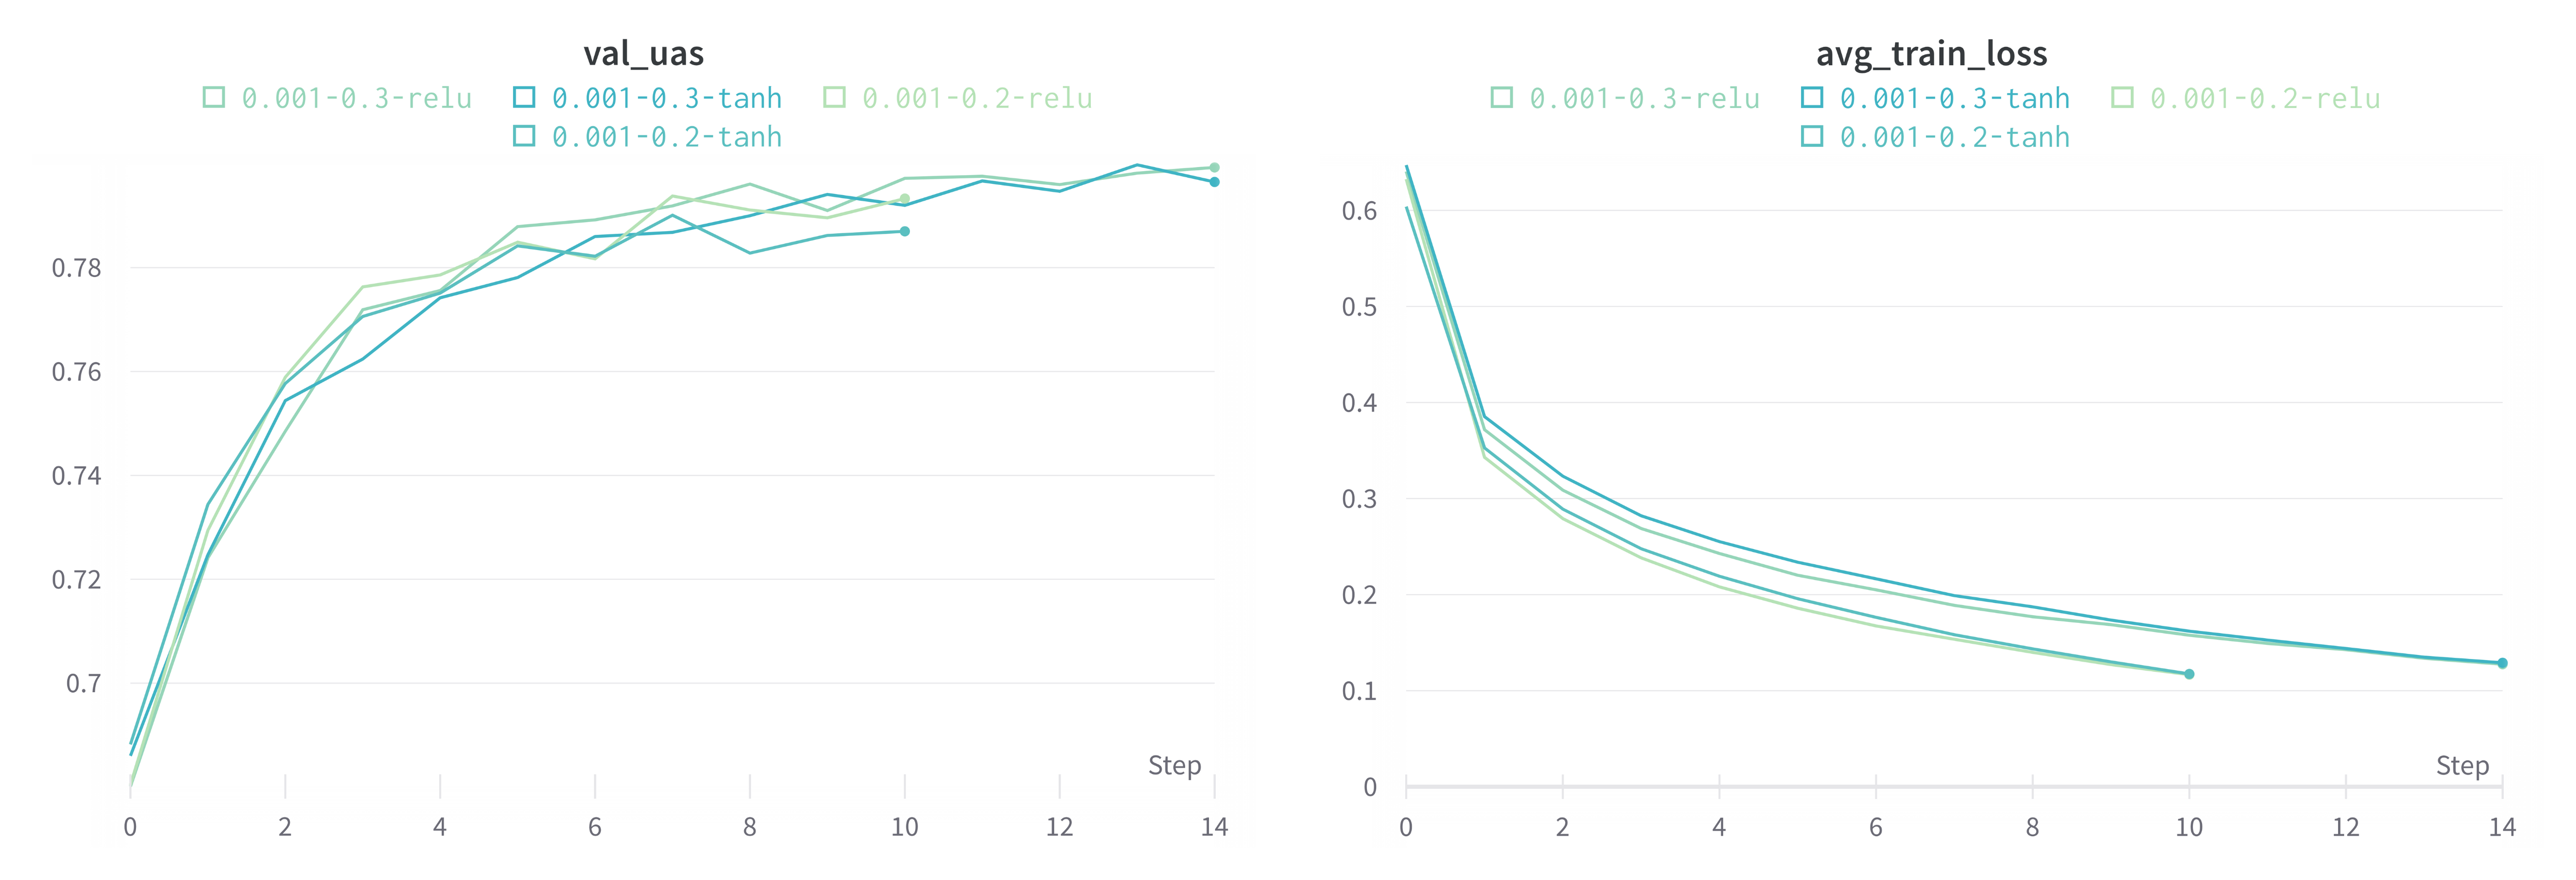

## BERT base

In [51]:
df_BERT = df_result.drop(['LSTM_score', 'LSTM_L2_score',	'BERT_ft_score'], axis = 1)
df_BERT.insert(0, 'run', np.arange(1, 13))
df_BERT = df_BERT.sort_values(by='BERT_score', ascending=False)

styler_BERT = df_BERT.style.background_gradient(axis=0, gmap=df_BERT['run'], cmap=cmap).hide(axis="index")
styler_BERT.set_properties(**{'text-align': 'center'})

html_table3 = styler_BERT.to_html()
title3 = "<h2>BERT base </h2>"
html = f"""
<div style="display: inline-block; vertical-align: top;">
    {title3}
    {html_table3}
</div>
"""
display(HTML(html))

**TOP 4 configurations**

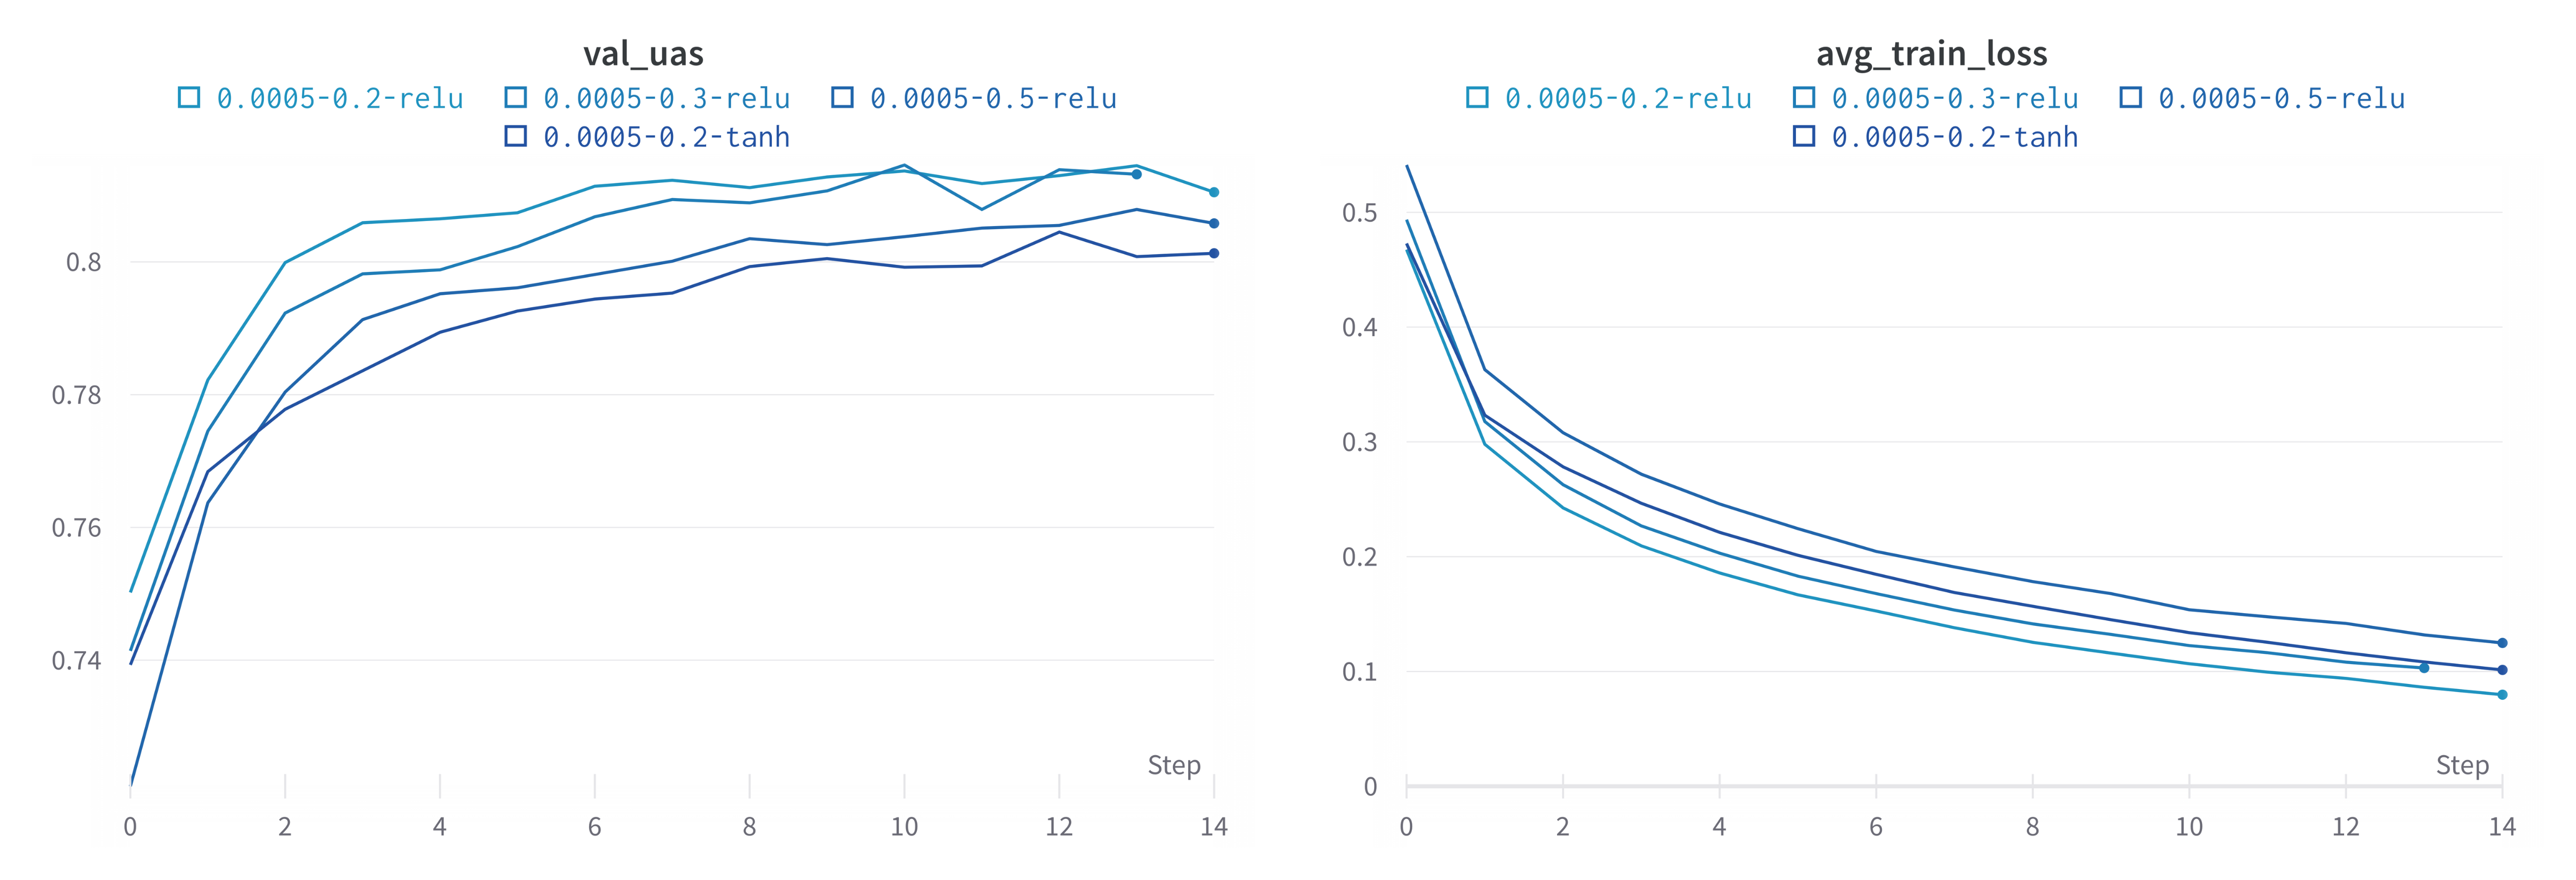

## BERT-FineTuned

In [52]:
df_BERT_ft = df_result.drop(['LSTM_score', 'LSTM_L2_score',	'BERT_score'], axis = 1)
df_BERT_ft.insert(0, 'run', np.arange(1, 13))
df_BERT_ft = df_BERT_ft.sort_values(by='BERT_ft_score', ascending=False)

styler_BERT_ft = df_BERT_ft.style.background_gradient(axis=0, gmap=df_BERT_ft['run'], cmap=cmap).hide(axis="index")
styler_BERT_ft.set_properties(**{'text-align': 'center'})


html_table4 = styler_BERT_ft.to_html()
title4 = "<h2>BERT Fine Tuned </h2>"
html = f"""
<div style="display: inline-block; vertical-align: top;">
    {title4}
    {html_table4}
</div>
"""
display(HTML(html))

**TOP 4 configurations**

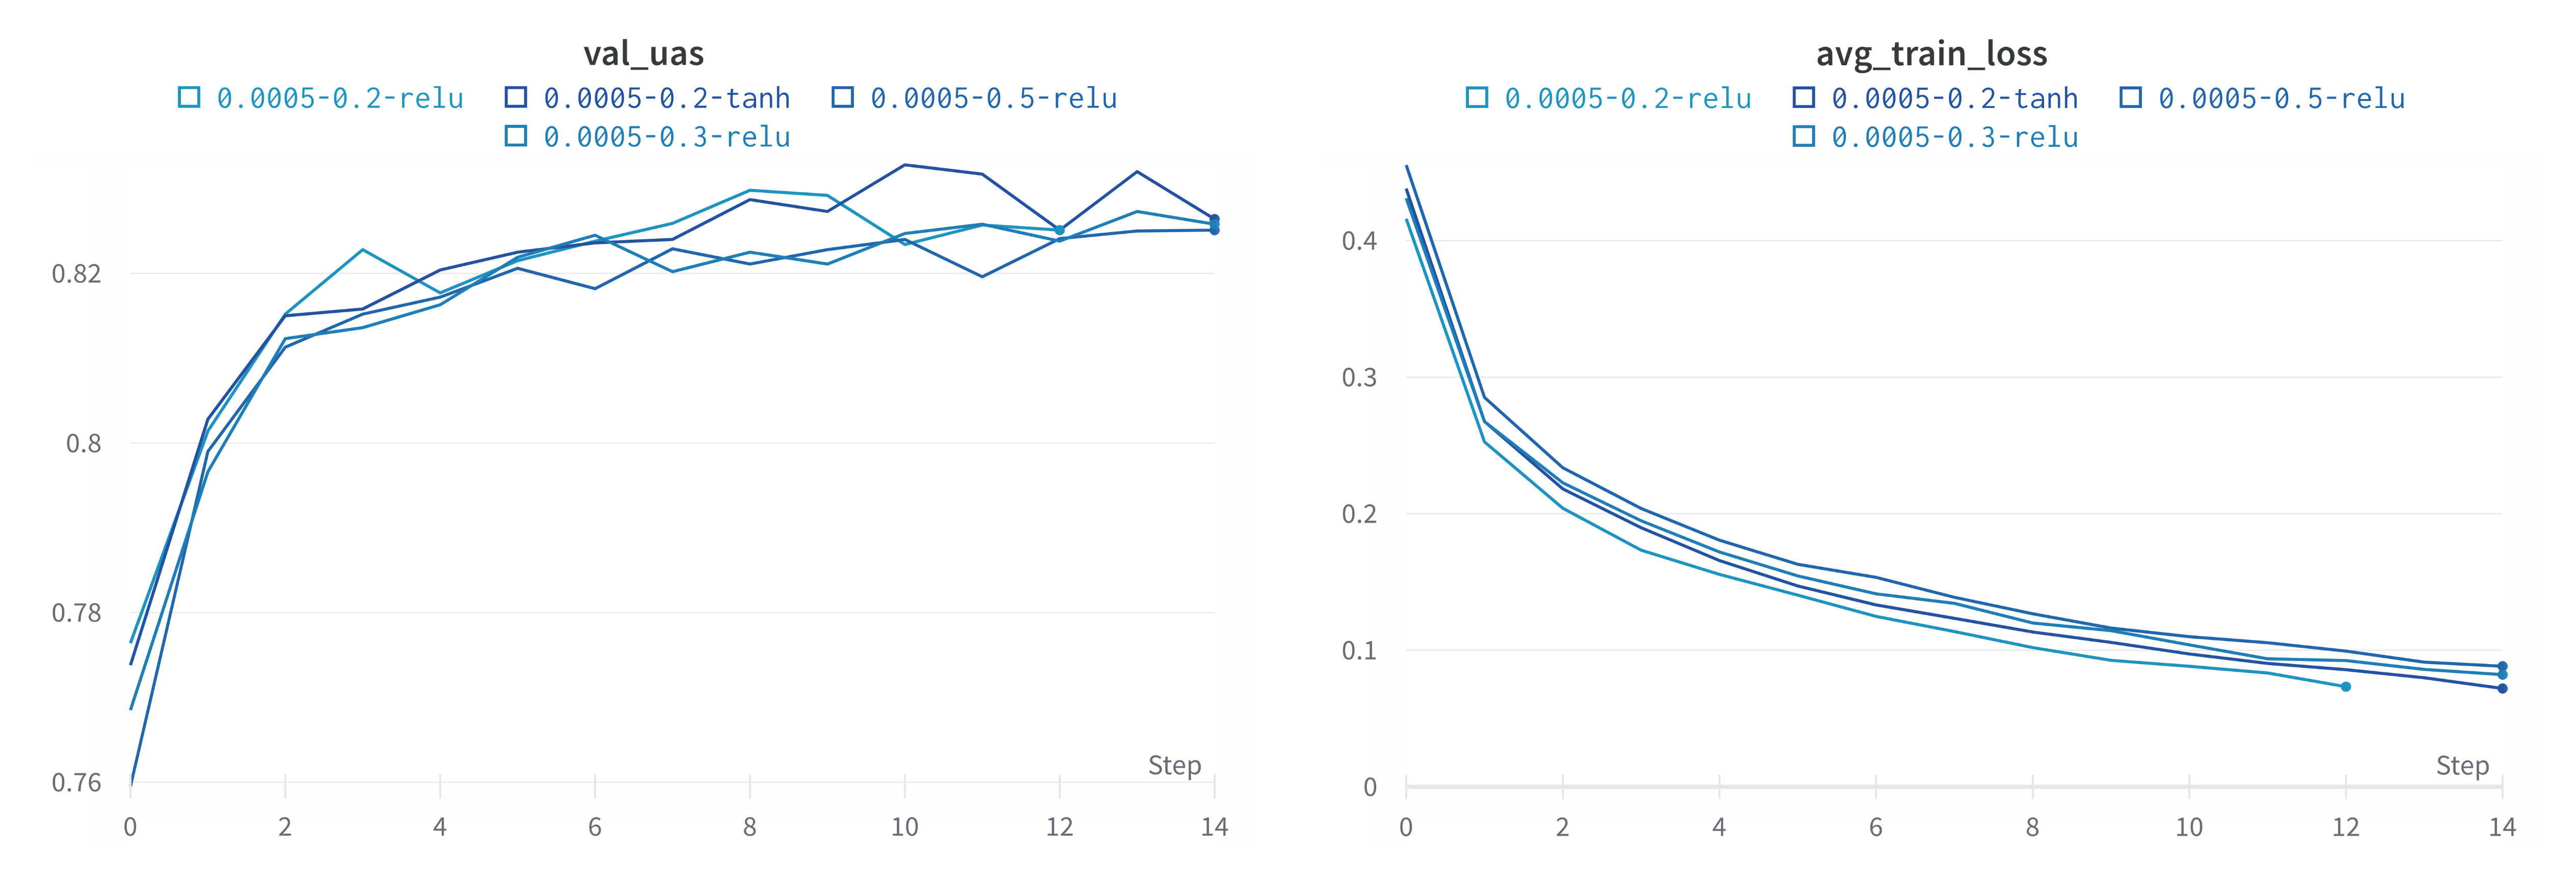

## Overall Comparison

In [53]:
html = f"""
<div style="display: inline-block; vertical-align: top;">
    {title1}
    {html_table1}
</div>

<div style="display: inline-block; vertical-align: top;">
    {title2}
    {html_table2}
</div>

<div style="display: inline-block; vertical-align: top;">
    {title3}
    {html_table3}
</div>

<div style="display: inline-block; vertical-align: top;">
    {title4}
    {html_table4}
</div>
"""

display(HTML(html))

Different models can be evaluated either intrinsically or extrinsically. Since ours is a study on an end-to-end application, ours is an extrinsic evaluation based on the UAS score (Unlabeled Attachment Score). Looking at these results, we can make two main points:
- The first is that in BERT models the **learning rate** is a very influential hyperparameter, in fact a smaller value led to better results (it can also be seen from the fact that the first rows of the tables on the right tended to be the darkest).
- We also note that, regardless of the hyperparameters chosen, the choice of **model architecture is decisive** for the average performance in this task, as it is shown in the following plot.


In [54]:
df_scores = df_result.drop(['learning_rate',	'DROPOUT', 	'act_function'], axis=1).astype(float)
average_scores = df_scores.mean()

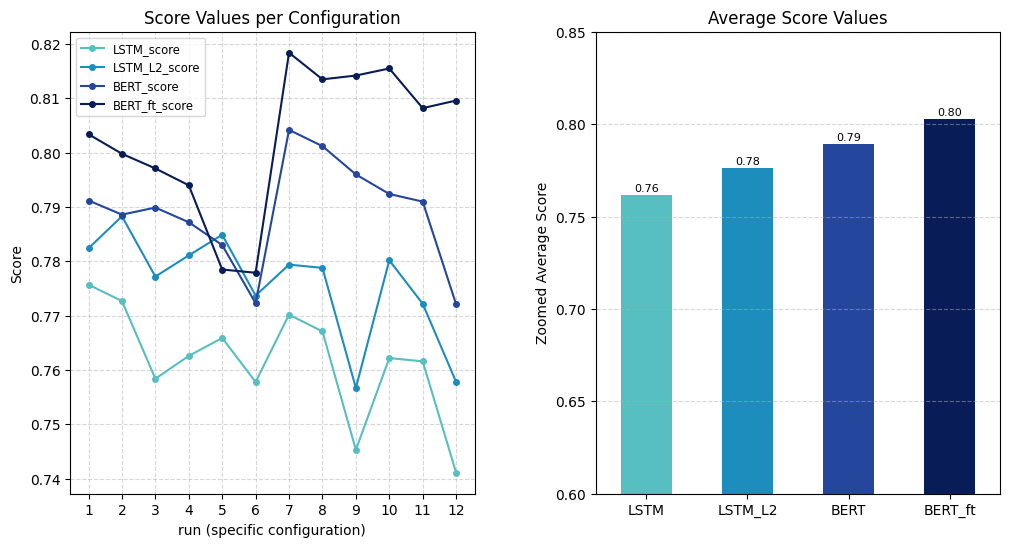

In [55]:
color_palette = [get_colors(12)[i-1] for i in range(13) if i > 4 and i % 2 == 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

df_scores.plot(y=["LSTM_score", "LSTM_L2_score", "BERT_score", "BERT_ft_score"],
               color=color_palette, marker="o", markersize=4, ax=ax1)

ax1.set_xticks(range(12))
ax1.set_xticklabels([i+1 for i in range(len(df_scores))])
ax1.set_xlabel("run (specific configuration)")
ax1.set_ylabel("Score")
ax1.set_title("Score Values per Configuration")
ax1.legend(loc="best", fontsize="small")
ax1.grid(True, linestyle="--", alpha=0.5)

average_scores.plot(kind="bar", color=color_palette, ax=ax2)
ax2.set_xlabel("")
ax2.set_ylabel("Zoomed Average Score")
ax2.set_ylim(0.6, 0.85)
ax2.set_title("Average Score Values")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
for p in ax2.patches:
    ax2.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8, color='black')
x_ticklabels = [label.get_text().replace("_score", "") for label in ax2.get_xticklabels()]
ax2.set_xticklabels(x_ticklabels, rotation=0)
ax2.grid(axis='y', linestyle='--', alpha=0.5)
plt.subplots_adjust(wspace=0.3)

plt.show()

### Our best model

Our best model happend to be **BERT_ft**, as it showed the best performance with a UAS score of **81,84** on the test set. Here is a comparisation among the best models of each architecture tried:

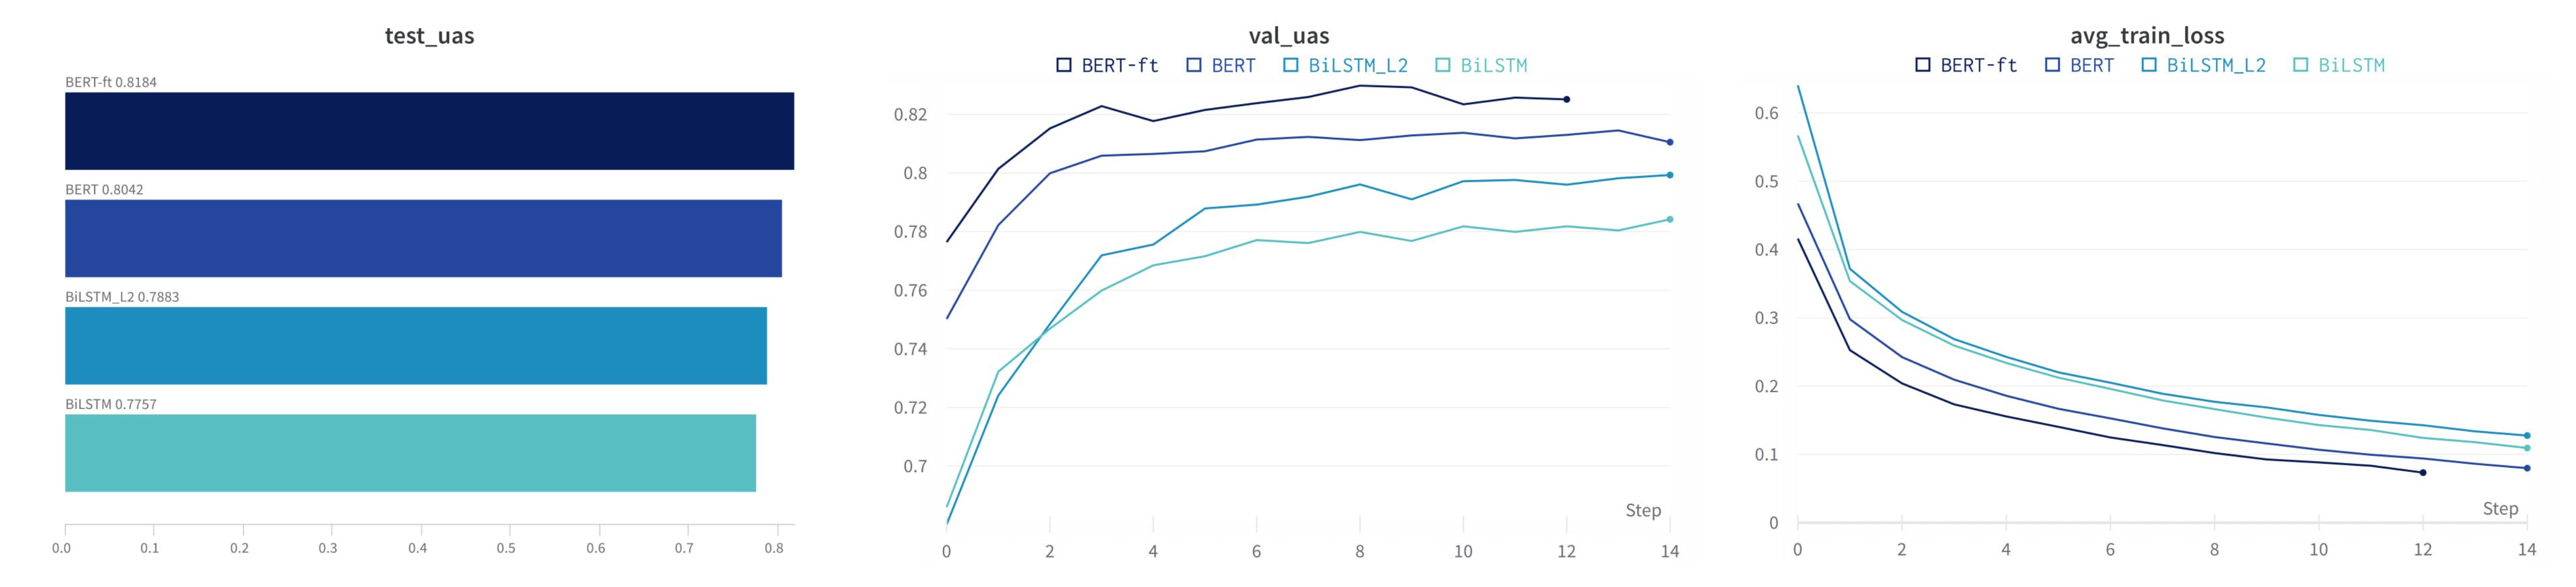

# Error Analysis


Once having fund the best model, we can proceed with the Erorr Analysis of BERT_ft. Lets first of all visualise four matricies:


1.   The **Confusion Matrix**. Note that a fifth label was added, and it rapresents each time the lenght of a dependency tree was different between the predicted tree and the gold one. This is a clear mistake of the model and can happen in several scenarios. We named this mistake '*overshoot*'.
2.   Accuracies Matrix, reporting the accuracy associated with each possible label. Here a very high *overshoot* value means that the gold threes and predicted thres are almost always of the same length.
3.  Recall Matrix, that is the following ratio: $ Recall = \frac{True\ Positive}{True\ Positive + False\ \textbf{Negative}} $

4. And finally the Precision Matrix:  $ Precision = \frac{True\ Positive}{True\ Positive + False\ \textbf{Positive}} $




We note that our best model shows the most overshoots when it has to predict right_arc or reduce. Since overshoot is the value attached at the end of the gold tree when it is shorter than the predicted one, we believe that RE and RA have more overshoots since they are the most common moves at the end of parsing. At any rate, the accuracy on overshoots is very high, meaning that the model tend to construct trees of the same length as the gold one, even if not always completely correct.

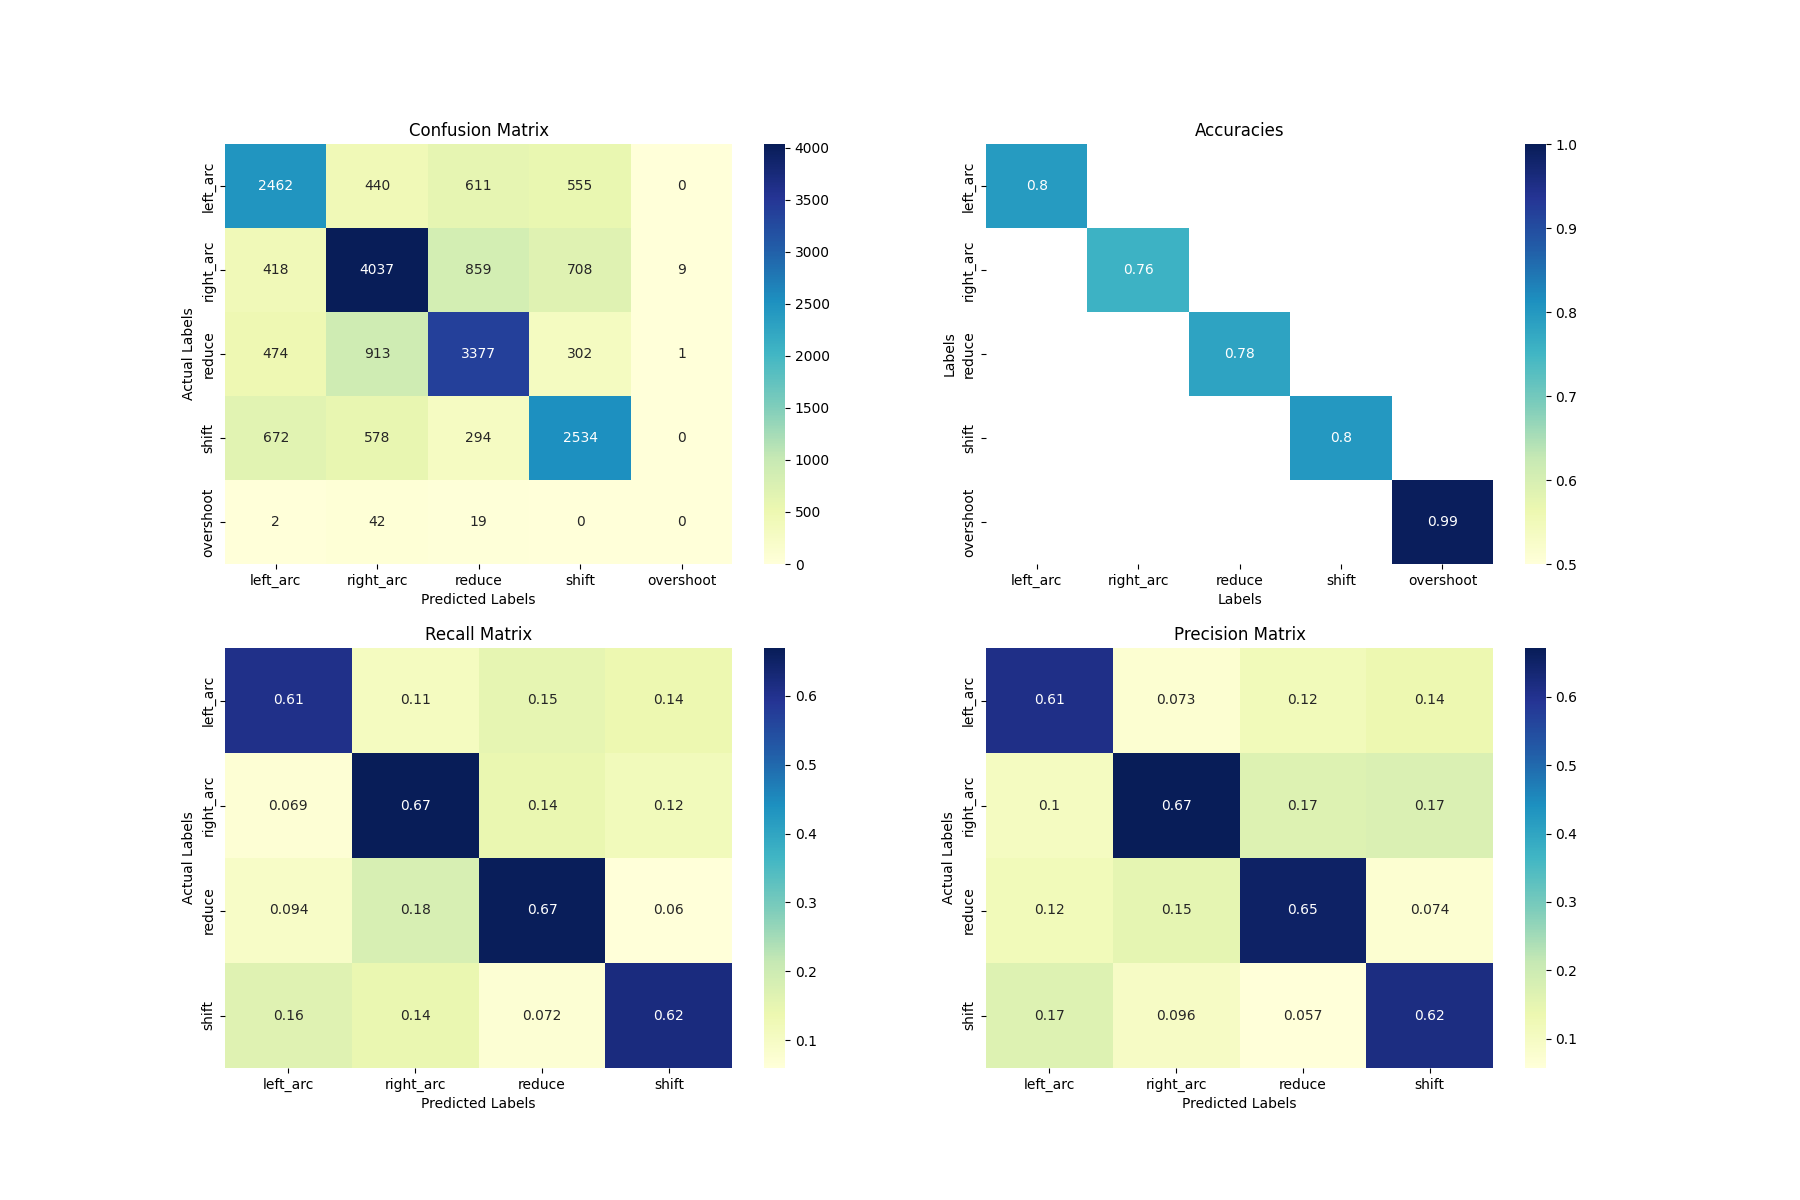

Besides individual moves, we analise how much the model errs in parsing full trees. We point out that since we trained the model only on projective trees, as the Arc Eager is limited to these types of graphs, unsurprisingly we obtained 0% accuracy on non-projective trees.

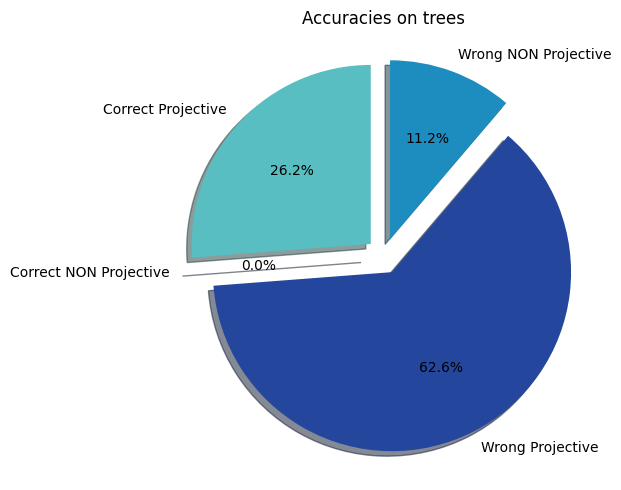

In [56]:
len_test = dataset['test'].num_rows
correct_tree = tree_acc*len_test
wrong_tree = len_test - correct_tree
wrong_non_proj = n_test_non_projective - correct_non_proj_BERT
x = [correct_tree - correct_non_proj_BERT, correct_non_proj_BERT, wrong_tree - wrong_non_proj, wrong_non_proj]

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.pie(x, labels=['Correct Projective', 'Correct NON Projective', 'Wrong Projective', 'Wrong NON Projective'],
        autopct='%1.1f%%', startangle=90, explode=(0.1, 0.1, 0.1, 0.1), colors=['#58bec1', '#081d58' ,'#24479d', '#1d8cbe'], shadow = True)
ax1.set_title('Accuracies on trees')

plt.tight_layout()
plt.show()

## SotA

### Comparison

Finally, we are refering to the current SotA to compare our models. The evaluation metric used for measuring performance on our task is the Unlabeled Attachment Score (**UAS**).
In the context of the unlabeled dependency parsing task, we are listing here the models that achieved the best UAS on our dataset, in decreasing order:

- With a **UAS score of 81,39**, the leading model is the ["UDPipe 2.0 with WE+CLE+BERT+Flair"](https://arxiv.org/pdf/1908.07448v1.pdf), which was evaluated on 89 corpora which have a training set in 54 languages of the Universal Dependencies 2.3 in three tasks. The abbrevations in its name stand for:
  - WE: Word Embedding of dimension 300 obtained using FastText word embeddings.
  - CLE: Character-Level word Embeddings, obtained by emploing a bidirectional GRUs of dimension 256.
  - BERT: Embedding of dimension 768 coming from three pretrained models: an English, a Chinese and multilingual one. The embedding of a UD word was retrieved as an average of BERT subword embeddings, as we did in our model.
  - Flair: Pretrained contextual word embeddings of dimension 4096 for available languages.

- The second best model is a similar but less complex architecture than the previous one, since it uses only the first two compents. The authors named it [UDPipe 2.0 with WE+CLE](https://arxiv.org/pdf/1908.07448v1.pdf) [same paper]. It reached a UAS score of **80.39**.

- The third model is model the *Universal Dependencies unify* - [UDIfy](https://arxiv.org/pdf/1904.02099v3.pdf) -  which obtained **80.05** as UAS score. As the previous ones, also UDify is "a multilingual multi-task model capable of accurately predicting universal part-of-speech, morphological features, lemmas, and dependency trees simultaneously for all different Universal Dependencies treebanks and across multiple languages".

- The fourth and last best model is ["UDPipe 2.0 Prototype"](https://aclanthology.org/K18-2020.pdf), a trainable pipeline which performs sentence segmentation, tokenization, POS tagging, lemmatization and dependency parsing. "It utilizes an artificial neural network with a single joint model for POS tagging, lemmatization and dependency parsing, and is trained only using the CoNLL-U training data and pretrained word embeddings". It,s UAS score is of **78.50**.




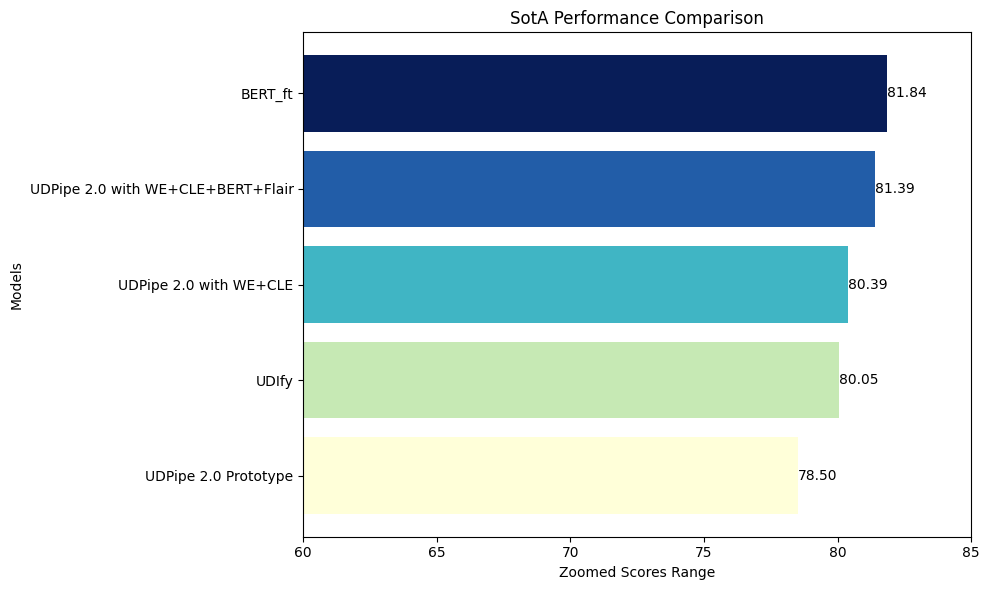

In [57]:
model_names = ['UDPipe 2.0 Prototype',
 'UDIfy',
 'UDPipe 2.0 with WE+CLE',
 'UDPipe 2.0 with WE+CLE+BERT+Flair',
 'BERT_ft']
model_scores = [78.5, 80.05, 80.39, 81.39, 81.84]

colors = get_colors(5)
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(model_names, model_scores, color=colors)
ax.set_xlim(60,85)
ax.set_ylabel('Models')
ax.set_xlabel('Zoomed Scores Range')
ax.set_title('SotA Performance Comparison')

bars = ax.barh(model_names, model_scores, color=colors)
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()

We are pleased to see that our model was able to surpass the State of the Art in dependecy parsing of this specific dataset.

Nonetheless, we believe that BERT_ft cannot replace State of the Art since it would most likely not achieve promising results when evaluated outside of the irish dataset on which it was fine-tuned and is not capable of doing other tasks besides the transition-based parsing for which it was trained (unlike instead the models presented as SotA).
